# Test how the water quality in different areas has changed in the past 20 years

0) data visualization, subset, and pivoting the datset. 

1) Selecting an area, define all the locations of which we have data, and devide them in freshwater, seawater, estuarine water, sewage. Checking if the locations are along the same river and between the same river's nodes

2) once the locations available are defined, look into the chemical of interested (so N, P, and Chl)

3) impute the missing data for the chemicals (GP might be the way to go), also utilising the data from the locations in the area which are in the same water category

In [1]:
import numpy as np
import sys
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplt_style_n
import seaborn as sns


plt.style.use(mplt_style_n.style1)

In [2]:
import scipy

#### Loading the dataframe

In [3]:
df = pd.read_csv('waterquality.csv', low_memory=False, index_col=0)

/home/nannil/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [4]:
df

@id  \
0        http://environment.data.gov.uk/water-quality/d...   
1        http://environment.data.gov.uk/water-quality/d...   
2        http://environment.data.gov.uk/water-quality/d...   
3        http://environment.data.gov.uk/water-quality/d...   
4        http://environment.data.gov.uk/water-quality/d...   
...                                                    ...   
3892352  http://environment.data.gov.uk/water-quality/d...   
3892353  http://environment.data.gov.uk/water-quality/d...   
3892354  http://environment.data.gov.uk/water-quality/d...   
3892355  http://environment.data.gov.uk/water-quality/d...   
3892356  http://environment.data.gov.uk/water-quality/d...   

                                      sample.samplingPoint  \
0        http://environment.data.gov.uk/water-quality/i...   
1        http://environment.data.gov.uk/water-quality/i...   
2        http://environment.data.gov.uk/water-quality/i...   
3        http://environment.data.gov.uk/water-quality/i...   
4        http://environment.data.gov.uk/water-quality/i...   
...                                                    ...   
3892352  http://environment.data.gov.uk/water-quality/i...   
3892353  http://environment.data.gov.uk/water-quality/i...   
3892354  http://environment.data.gov.uk/water-quality/i...   
3892355  http://environment.data.gov.uk/water-quality/i...   
3892356  http://environment.data.gov.uk/water-quality/i...   

        sample.samplingPoint.notation        sample.samplingPoint.label  \
0                         SO-19801A08            APSLEY FARM BOREHOLE A   
1                         SO-19801A08            APSLEY FARM BOREHOLE A   
2                         SO-19801A08            APSLEY FARM BOREHOLE A   
3                         SO-19801A08            APSLEY FARM BOREHOLE A   
4                         SO-19801A08            APSLEY FARM BOREHOLE A   
...                               ...                               ...   
3892352                   SO-Y0017594  MEDINA ESTUARY BENTHIC SEDIMENTS   
3892353                   SO-Y0017594  MEDINA ESTUARY BENTHIC SEDIMENTS   
3892354                   SO-Y0017594  MEDINA ESTUARY BENTHIC SEDIMENTS   
3892355                   SO-Y0017594  MEDINA ESTUARY BENTHIC SEDIMENTS   
3892356                   SO-Y0017594  MEDINA ESTUARY BENTHIC SEDIMENTS   

        sample.sampleDateTime determinand.label  \
0         2000-03-22T10:30:00           BOD ATU   
1         2000-03-22T10:30:00        Ammonia(N)   
2         2000-03-22T10:30:00                pH   
3         2000-03-22T10:30:00      Chloride Ion   
4         2000-03-22T10:30:00         COD as O2   
...                       ...               ...   
3892352   2022-07-18T14:28:00      Time Hi-Tide   
3892353   2022-07-18T14:28:00       phi 7.5-8.0   
3892354   2022-07-18T14:28:00        GSF >63000   
3892355   2022-07-18T14:28:00       phi 8.0-8.5   
3892356   2022-07-18T14:28:00       Water Depth   

                       determinand.definition  determinand.notation  \
0                             BOD : 5 Day ATU                    85   
1                    Ammoniacal Nitrogen as N                   111   
2                                          pH                    61   
3                                    Chloride                   172   
4             Chemical Oxygen Demand :- {COD}                    92   
...                                       ...                   ...   
3892352                     Time of high tide                     4   
3892353  Grain Size Fraction : phi 7.5 to 8.0                  7484   
3892354           Grain Size : >63000 microns                  4131   
3892355  Grain Size Fraction : phi 8.0 to 8.5                  7485   
3892356                           Water Depth                  3428   

        resultQualifier.notation  result  \
0                              <    3.00   
1                              <    0.50   
2                            NaN    7.15   
3                     

In [5]:
df.columns

Index(['@id', 'sample.samplingPoint', 'sample.samplingPoint.notation',
       'sample.samplingPoint.label', 'sample.sampleDateTime',
       'determinand.label', 'determinand.definition', 'determinand.notation',
       'resultQualifier.notation', 'result',
       'codedResultInterpretation.interpretation', 'determinand.unit.label',
       'sample.sampledMaterialType.label', 'sample.isComplianceSample',
       'sample.purpose.label', 'sample.samplingPoint.easting',
       'sample.samplingPoint.northing'],
      dtype='object')

## 0a) Write the dataset in a better format, where a given time and place appear just once with all the results on the same row.

The dataset is very big, we construct a subset with the information we want to study, i.e. water and weather conditions/properties, and phosphate and nitrogen based nutrients

In [6]:
set(df["determinand.definition"])

{'Nickel, HF Digest : Dry Wt',
 '1,2,3-Trichloropropane, Leachable',
 'MCPB :- {4-Chloro-2-methylphenoxybutyric acid}',
 'Phenol : Dry Wt',
 'Dibenzofuran',
 'PCB - 081 : Wet Wt',
 'Equiv.Carbon No >21-35, Aliphatic fraction : Dry Wt',
 '1,2,3,4,6,7,8-Heptachlorodibenzofuran : Wet Wt',
 'Salinity',
 '2-Nitroaniline',
 'Dibenzothiophenes : C1 : Wet Wt',
 'Sulphur Elemental : Dry Wt',
 'BOD : 5 Day ATU, Leachable',
 'Equiv.Carbon No >21-35, Aliphatic Fraction',
 '1,2-Dichloropropane, Leachable',
 '9-chlorohexadecafluoro-3-oxanonane-1-sulfonic acid',
 '2,2,4,4 Tetrabromodiphenyl ether : Wet Wt',
 'PCB - 149 : Dry Wt',
 'Equiv.Carbon No >24-44, Aromatic Fraction',
 'Octachlorodibenzofuran : Wet Wt',
 'Tetramethyl Lead',
 'Cyclohexyl Tin as Cation',
 'Perfluorododecane sulfonic acid',
 'Carbon Dioxide : as % V/V CO2',
 'Propyzamide : Dry Wt',
 'Chlorophyll a + b',
 'Cresyldiphenyl phosphate',
 'Equiv.Carbon No >20-44 : Dry Wt',
 'Formaldehyde :- {Methanal}',
 'Potassium, Leachable : Dry Wt'

In [7]:
serch_for = ["water", "liquid", "salinity", "tide", "weather", "depth", "river", "sewage", "estuary"]

In [8]:
set(np.unique(df[df["determinand.definition"].str.contains('|'.join(serch_for), case=False)==True]["determinand.definition"]))

{'Animal faeces, Strandline to waters edge',
 'Bathing Water Profile : Algal Bloom',
 'Bathing Water Profile : Animal Faeces',
 'Bathing Water Profile : Dead Marine Life',
 'Bathing Water Profile : Macroalgae',
 'Bathing Water Profile : Oil and Tar',
 'Bathing Water Profile : Other Litter (incl. plastics)',
 'Bathing Water: Plastics',
 'Borehole : Depth to liquid :- {Ground level to liquid}',
 'Borehole : Depth total, Metres below datum',
 'Boron, Boiling water soluble : Dry Wt',
 'Depth relative to Chart Datum',
 'Marine algae, Waters edge',
 'River flow status',
 'Salinity',
 'Salinity : Calculated from Chloride',
 'Salinity : In Situ',
 'Salinity : Refractometer : Intertidal, Interstitial',
 'Salinity, by Bench Salinometer',
 'Salinity, by Conductivity',
 'Sample Depth below surface',
 'Secchi depth',
 'Sewage debris',
 'Temperature of Water',
 'Time of high tide',
 'Time of sampling relative to previous high water',
 'Unusual Weather Waiver (WRA)',
 'Warning Sign - Short Term Bathi

In [9]:
water_determinants = np.unique(df[df["determinand.definition"].str.contains('|'.join(serch_for), case=False)==True]["determinand.definition"])

In [10]:
df.loc[df['determinand.definition'].isin(water_determinants) ].groupby(['determinand.definition']).count().sort_values(by="sample.samplingPoint.notation", ascending=False)["sample.samplingPoint.notation"]

determinand.definition
Temperature of Water                                      155005
Salinity : In Situ                                         45671
Time of high tide                                          17686
Sewage debris                                              16422
Bathing Water Profile : Other Litter (incl. plastics)      13944
Bathing Water Profile : Algal Bloom                        13943
Bathing Water Profile : Animal Faeces                      13942
Bathing Water Profile : Macroalgae                         13941
Weather : Rainfall : Coded                                 12218
Weather : Wind Direction : Degrees                         11894
Sample Depth below surface                                 10720
Weather : Cloud Cover                                       9362
Marine algae, Waters edge                                   9355
Weather : Wind Speed                                        9344
Weather : Sunshine : Coded                                  9335
Wa

In [11]:
nutrients_N = [119,111,9993,117,9853,118,6485,4925,114,116,9943,9686 ] #12 determinands linked to  Nitrogen
nutrients_P = [9856, 180, 348] # 3 determinants linked to the Phosphate

In [12]:
nutrients_Chl_Salinity = [947, 7608]

In [13]:
Nutrients_N_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_N)]["determinand.definition"]))
Nutrients_P_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_P)]["determinand.definition"]))

In [14]:
Nutrients_Chl_Salinity_names = list(np.unique(df[df["determinand.notation"].isin(nutrients_Chl_Salinity)]["determinand.definition"]))

#### Here we create a subset of the dataframe only looking at results about water and nutrients linked to nitrogen and phosphate

In [15]:
df_sub = df.loc[(df['determinand.definition'].isin(water_determinants)) | (df['determinand.notation'].isin(nutrients_N)| (df['determinand.notation'].isin(nutrients_P)| (df['determinand.notation'].isin(nutrients_Chl_Salinity)))) ]


#### Add a Date column, so ignoring the time

In [16]:
df_sub.loc[:, "Date"] = pd.to_datetime(df_sub['sample.sampleDateTime']).dt.date.values


/home/nannil/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


### Let's study the lower limits

In [17]:
df_sub.loc[:,"resultQualifier.notation"] = np.where(df_sub["resultQualifier.notation"]=="<", 0, 1)


/home/nannil/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<AxesSubplot:xlabel='resultQualifier.notation', ylabel='Percent'>

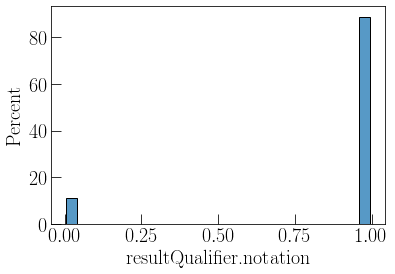

In [18]:
sns.histplot(df_sub, x="resultQualifier.notation", stat="percent", multiple="dodge", shrink=.8)



#### Less then 20% of the results are lower limits, we substitue them with 0


In [19]:
df_sub.loc[df_sub["resultQualifier.notation"]==0, "result"] = 0

/home/nannil/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


#### since it is a big dataframe, we also exclude columns that are not important for the analysis before pivoting


In [20]:
df_sub_drop = df_sub.drop(columns=['@id', 'sample.samplingPoint', 'determinand.notation', 'determinand.label', 'sample.sampleDateTime', 'determinand.unit.label',"codedResultInterpretation.interpretation","resultQualifier.notation", 'sample.isComplianceSample' , 'sample.purpose.label'])

In [21]:
df_piv = df_sub_drop.pivot_table('result',\
list(df_sub_drop.drop(columns=['result', 'determinand.definition']).columns), 'determinand.definition').reset_index().rename_axis(None, axis=1)



In [22]:
df_piv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211492 entries, 0 to 211491
Data columns (total 62 columns):
 #   Column                                                  Non-Null Count   Dtype  
---  ------                                                  --------------   -----  
 0   sample.samplingPoint.notation                           211492 non-null  object 
 1   sample.samplingPoint.label                              211492 non-null  object 
 2   sample.sampledMaterialType.label                        211492 non-null  object 
 3   sample.samplingPoint.easting                            211492 non-null  int64  
 4   sample.samplingPoint.northing                           211492 non-null  int64  
 5   Date                                                    211492 non-null  object 
 6   Ammonia un-ionised as N                                 73005 non-null   float64
 7   Ammoniacal Nitrogen as N                                149554 non-null  float64
 8   Ammoniacal Nitrogen, Fil

#### Studying the NaNs

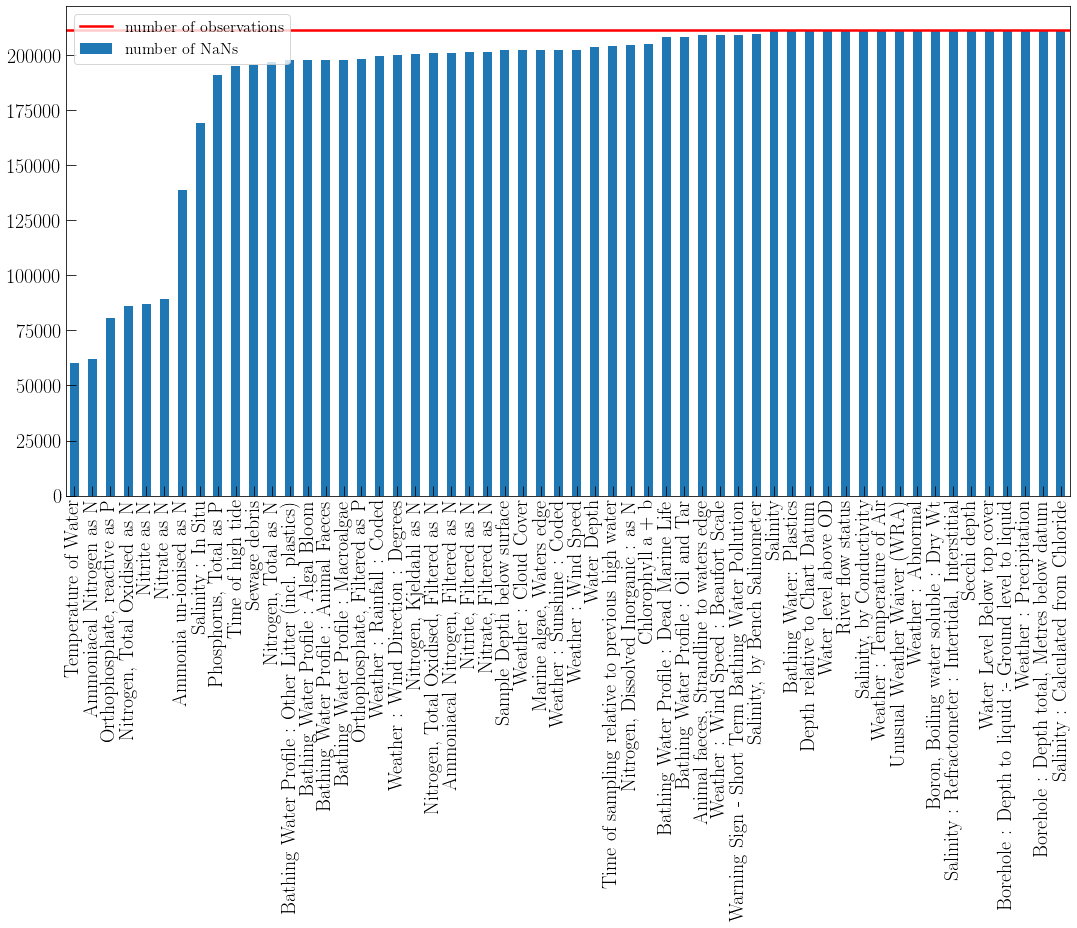

In [23]:
missing = df_piv.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots(figsize=(18,9))


missing.plot.bar(label="number of NaNs");
plt.axhline(y=df_piv.shape[0], color="red", label="number of observations")
plt.legend(fontsize=16)

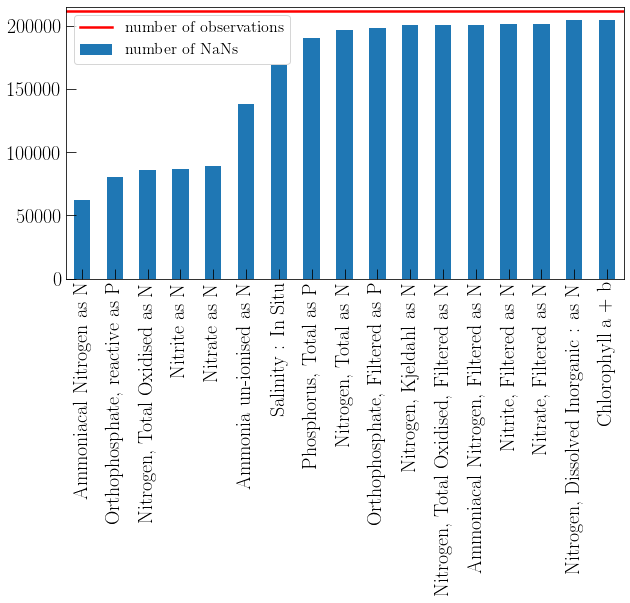

In [24]:
missing = df_piv[Nutrients_N_names+Nutrients_P_names+Nutrients_Chl_Salinity_names].isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots(figsize=(10,5))


missing.plot.bar(label="number of NaNs");
plt.axhline(y=df_piv.shape[0], color="red", label="number of observations")
plt.legend(fontsize=16)

In [25]:
df_piv.loc[:,"year"] = pd.to_datetime(df_piv['Date']).dt.year


In [26]:
df_piv.loc[:,"month"] = pd.to_datetime(df_piv['Date']).dt.month


#### Encoding Season

In [27]:
df_piv["season"] = np.where((df_piv["month"]>4)&(df_piv["month"]<9), 0, 1)

In [28]:
df_piv.sort_values(by="Date", ascending=True)

sample.samplingPoint.notation               sample.samplingPoint.label  \
109630                   SO-G0003581             HOOK SAMPLING POINT-*CLOSED*   
45676                    SO-F0002352               HORSTED PLACE STW-*CLOSED*   
109086                   SO-G0003567  SOTON WATER NEAR CADLAND CREEK-*CLOSED*   
42787                    SO-F0002290                 R UCK HASTINGFORD BRIDGE   
35392                    SO-F0002151                    R OUSE BARCOMBE MILLS   
...                              ...                                      ...   
19223                    SO-F0001919           MIDDLETON ON SEA EC BW (15600)   
7002                     SO-E0004787             BEXHILL BATHING SITE (14200)   
194365                   SO-Y0004270                            COWES (17800)   
187134                   SO-G0017029            SOUTHSEA EAST EC SITE (16600)   
210206                   SO-Y0004516                       EAST COWES (17850)   

       sample.sampledMaterialType.label  sample.samplingPoint.easting  \
109630                  ESTUARINE WATER                        448950   
45676             FINAL SEWAGE EFFLUENT                        546630   
109086                  ESTUARINE WATER                        444800   
42787     RIVER / RUNNING SURFACE WATER                        552400   
35392     RIVER / RUNNING SURFACE WATER                        543300   
...                                 ...                           ...   
19223                         SEA WATER                        498500   
7002                          SEA WATER                        574042   
194365                        SEA WATER                        448800   
187134                        SEA WATER                        465000   
210206                        SEA WATER                        450642   

        sample.samplingPoint.northing        Date  Ammonia un-ionised as N  \
109630                         103290  2000-01-04                   0.0022   
45676                          118670  2000-01-04                   0.0237   
109086                         105600  2000-01-04                   0.0031   
42787                          125800  2000-01-04                   0.0004   
35392                          114800  2000-01-04                   0.0010   
...                               ...         ...                      ...   
19223                           99900  2022-09-20                      NaN   
7002                           107018  2022-09-20                      NaN   
194365                          96700  2022-09-20                      NaN   
187134                          98080  2022-09-20                      NaN   
210206                          96377  2022-09-20                      NaN   

        Ammoniacal Nitrogen as N  Ammoniacal Nitrogen, Filtered as N  \
109630                     0.161                                 NaN   
45676                     11.300                                 NaN   
109086                     0.253                                 NaN   
42787                      0.075                                 NaN   
35392                      0.157                                 NaN   
...                          ...                                 ...   
19223                        NaN                                 NaN   
7002                         NaN                                 NaN   
194365                       NaN                                 NaN   
187134                       NaN                                 NaN   
210206                       NaN                                 NaN   

        Animal faeces, Strandline to waters edge  ...  \
109630                                       NaN  ...   
45676                                        NaN  ...   
109086                                       NaN  ...   
42787                                        NaN  ...   
35392                                        NaN  ...   
...          

# 0b) Nutrients Overview

#### a) Outliers when quantiles <0.01 and >0.9

In [29]:
def quantiles_check(df, nutrients):
    q_low = df[nutrients[0::]].quantile(0.01)
    q_hi  = df[nutrients[0::]].quantile(0.99)
    
    df_return = df.copy()
    df_return[nutrients[0::]] = np.where( ((df[nutrients[0::]] < q_hi) & (df[nutrients[0::]] > q_low)), df[nutrients[0::]], np.nan)
    return df_return

Return  for outliers

In [30]:
df_piv_out = quantiles_check(df_piv, Nutrients_N_names + Nutrients_P_names+Nutrients_Chl_Salinity_names)

#### b) Studying NaNs and their distribution in time

In [31]:
import missingno as msno  # # pip install missingno


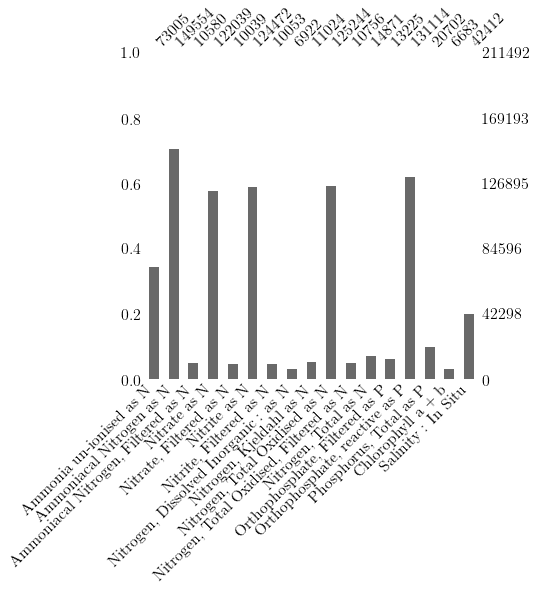

In [32]:
msno.bar(df_piv[Nutrients_N_names+Nutrients_P_names+Nutrients_Chl_Salinity_names], figsize=(6,6));

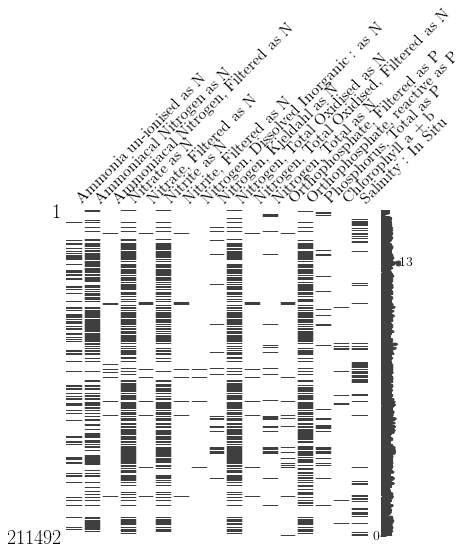

In [33]:

msno.matrix(df_piv_out[Nutrients_N_names+Nutrients_P_names+Nutrients_Chl_Salinity_names], figsize=(6,6));

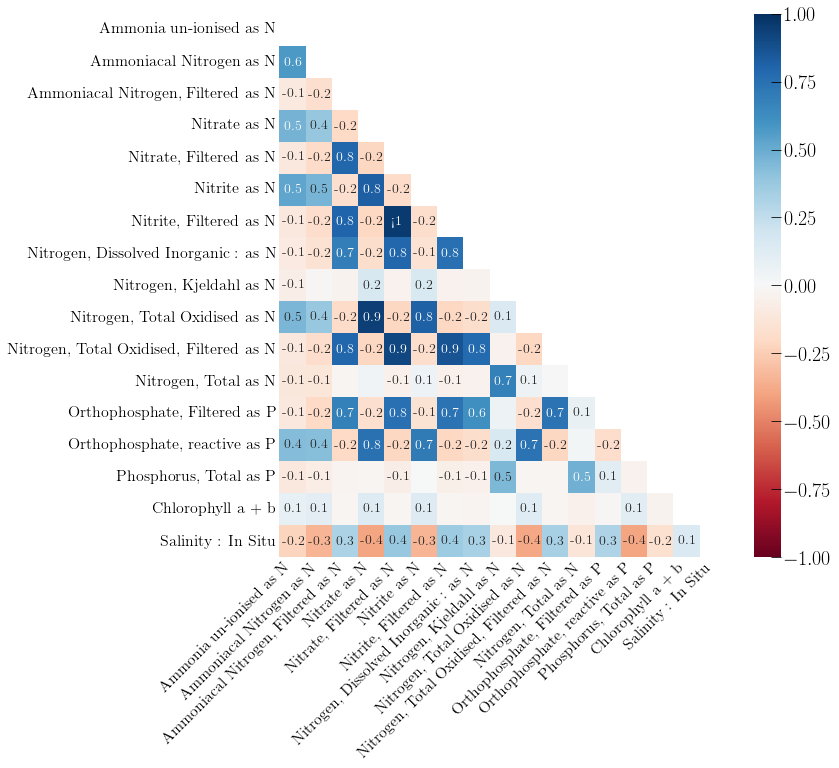

In [34]:
msno.heatmap(df_piv_out[Nutrients_N_names+Nutrients_P_names+Nutrients_Chl_Salinity_names], figsize=(10,10));

##### We have nutrients that are basically always calculated at the same time while it s not true the opposite: we do not have nutrients that are always computed when others are not 

#### c) studying the covariance

In [35]:
color_P = ["#0B262D",  "#DCF059", "#360F00"]

color_N = ["#0B262D", "#055B61", "#36ABA1","#58B081", "#8BC07E", "#DCF059", "#F6FF4C", "#DBB63E", "#C06C2F", \
          "#B54820", "#952902", "#360F00"]


In [36]:
def plot_nutrientsdate(df, nutrients_name, plot_title, color_N, figsize_ = (10,14), bbox_to_anchor_=(1., .5), fontsize_ = 16, sct_kwargs={}):
    fig, ax = plt.subplots(nrows=len(nutrients_name),ncols=1, sharex=True, figsize=figsize_)
    if len(nutrients_name)> 1:
        for i in range(len(nutrients_name)):
            ax[i].scatter(pd.to_datetime(df["Date"]), df[nutrients_name[i]], label=str(nutrients_name[i]), color=color_N[i], **sct_kwargs)

        ax[len(nutrients_name)-1].set_xlabel("time")
    	
        fig.legend(bbox_to_anchor=bbox_to_anchor_, fontsize=fontsize_)
        if plot_title != None:
            ax[0].set_title(label=str(plot_title), fontsize=22)
    if len(nutrients_name)== 1:

        ax.scatter(pd.to_datetime(df["Date"]), df[nutrients_name], label=str(nutrients_name), color=color_N, **sct_kwargs)

        ax.set_xlabel("time")
    	
        fig.legend(bbox_to_anchor=bbox_to_anchor_, fontsize=fontsize_)
        if plot_title != None:
            ax.set_title(label=str(plot_title), fontsize=22)

    return(ax)

In [37]:
scatter_params = {'s':15, 'alpha':0.5, 'marker':"."}


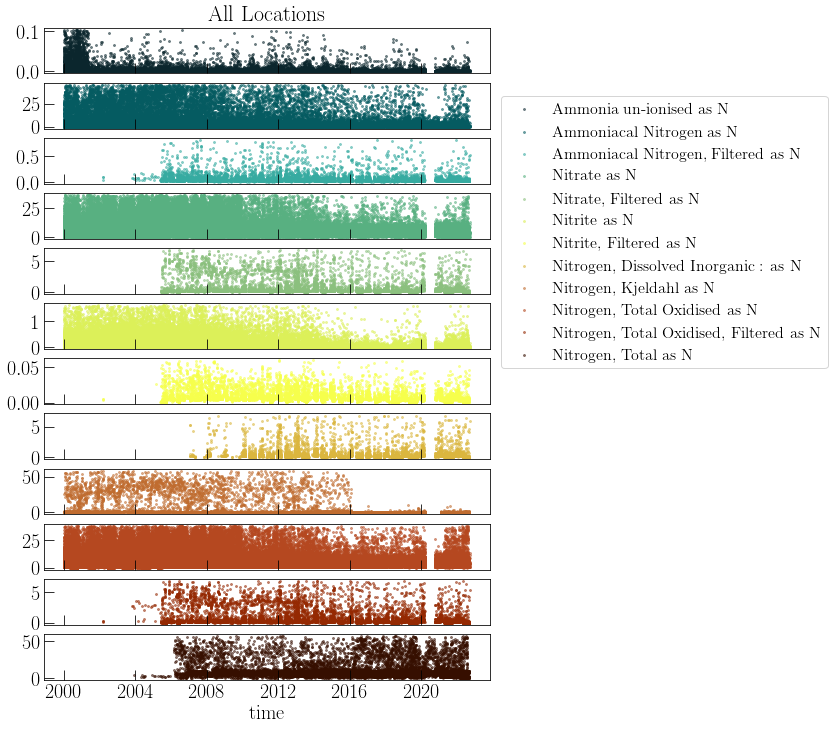

In [38]:
plot_nutrientsdate(df_piv_out,Nutrients_N_names, \
           "All Locations",\
          color_N, bbox_to_anchor_=(1.5, .81), figsize_ = (8,12), sct_kwargs = scatter_params);

array([<AxesSubplot:title={'center':'All Locations'}>, <AxesSubplot:>,
       <AxesSubplot:xlabel='time'>], dtype=object)

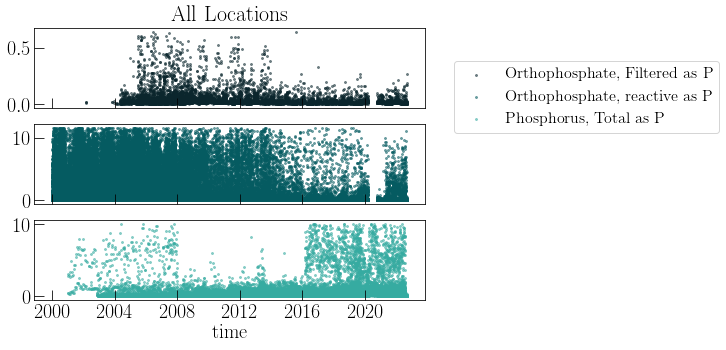

In [39]:
plot_nutrientsdate(df_piv_out,Nutrients_P_names, \
           "All Locations",\
          color_N, bbox_to_anchor_=(1.5, .81), figsize_ = (7,5), sct_kwargs = scatter_params)

#### d) study if similar named nutrients have been used instead of one another 

#### As from the NaNs, also from here we can see how this hasn't happened

#### Nitrate and Nitrite

Nitrate as N [117][Nitrate-N]

Nitrate, Filtered as N [9853][ Nitrate Filt]

Nitrite as N [118][Nitrite-N]

Nitrite, Filtered as N [6485][Nitrite Filt]

In [40]:
NitrateNitrite_names = list(np.unique(df[df["determinand.notation"].isin([117,9853,118,6485])]["determinand.definition"]))

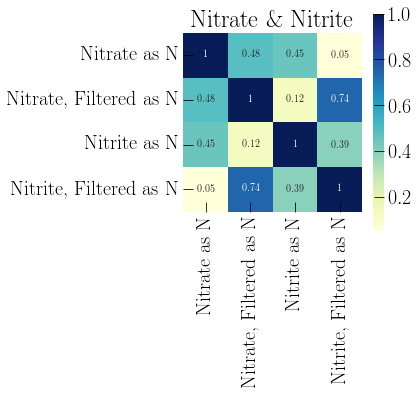

In [41]:
corrmat_NN = df_piv_out[NitrateNitrite_names].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.heatmap(corrmat_NN, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Nitrate \& Nitrite");

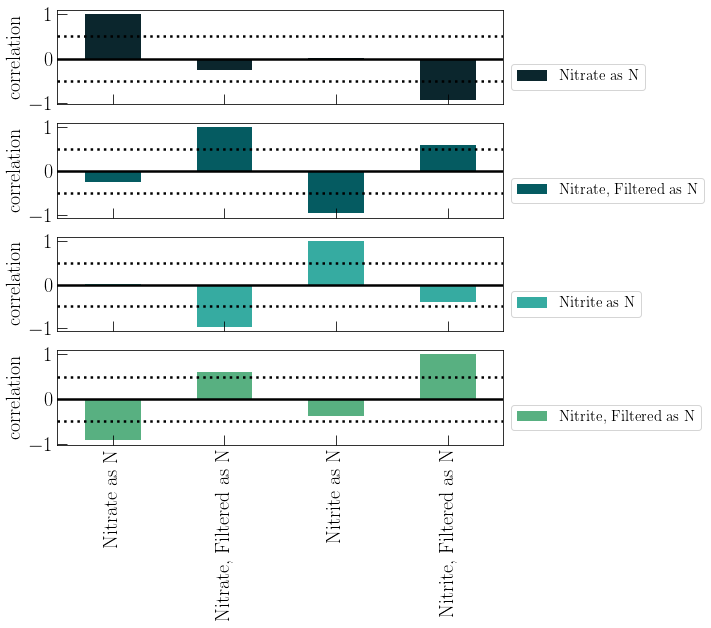

In [42]:
fig, ax = plt.subplots(nrows=len(NitrateNitrite_names),ncols=1, sharex=True, figsize=(8,8))
for i, N in enumerate(NitrateNitrite_names):
    corrmat_NN.corr()[N].plot.bar(ax = ax[i],  alpha=1, label=str(N), color = color_N[i])
    ax[i].legend(fontsize=15, bbox_to_anchor=(1,.5))
    ax[i].axhline(y=0, color="black")
    ax[i].axhline(y=0.5, color="black", linestyle=":")
    ax[i].axhline(y=-0.5, color="black", linestyle=":")
    ax[i].set_ylabel("correlation")

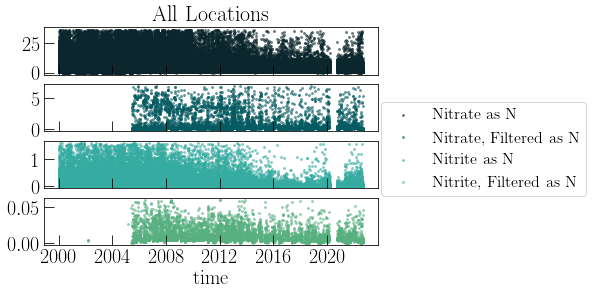

In [43]:
fig = plot_nutrientsdate(df_piv_out,NitrateNitrite_names, "All Locations",\
          color_N, bbox_to_anchor_=(1.4, .65), figsize_ = (6,4), sct_kwargs = scatter_params)

##### Check if the Filtered is studied when the nutrient is low!

In [44]:
NitrateNitrite_names[0], NitrateNitrite_names[1]

('Nitrate as N', 'Nitrate, Filtered as N')

/home/nannil/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


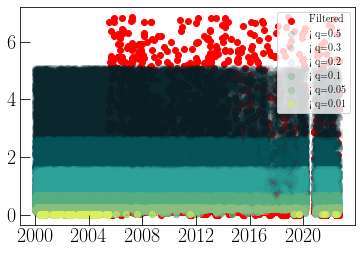

In [45]:
qua = [0.5, 0.3, 0.2, 0.1, 0.05, 0.01]
alph = [0.1, 0.1, 0.1, 0.3, 0.4, 0.5]

plt.scatter(df_piv_out["Date"], df_piv_out[NitrateNitrite_names[1]], color="red", label="Filtered")

for i in range(len(qua)):
    plt.scatter(df_piv_out[df_piv_out[NitrateNitrite_names[0]]<df_piv_out[NitrateNitrite_names[0]].quantile(qua[i])]["Date"], 
                df_piv_out[df_piv_out[NitrateNitrite_names[0]]<df_piv_out[NitrateNitrite_names[0]].quantile(qua[i])][NitrateNitrite_names[0]], 
                alpha=alph[i], color = color_N[i], label="< q="+str(qua[i]))
    

plt.legend()


##### From here we see that:

1) The filtered values are lower

2) They have been studied later, but as something more, not substituing

#### Let's investigate if there are locations where filtered and not filtered are studied at the same time

In [46]:
df_piv_out[df_piv_out["Nitrate, Filtered as N"].notna()&df_piv_out["Nitrate as N"].notna()][NitrateNitrite_names]

Nitrate as N  Nitrate, Filtered as N  Nitrite as N  \
34414         2.110                  0.3750        0.0074   
87076        11.400                  0.1480        0.0807   
87080         1.210                  2.3500        0.0258   
87083         1.230                  1.8400        0.0325   
87084         0.191                  0.1970        0.0087   
87086         1.530                  1.5600        0.0386   
87088         0.211                  0.5570        0.0192   
87089         0.185                  0.8530        0.0152   
87093         0.237                  0.8840        0.0134   
87097         0.193                  0.4910        0.0069   
87099         0.193                  0.3000        0.0073   
87101         0.195                  0.3930        0.0046   
87103         3.550                  3.5500        0.0365   
87105         0.947                  1.0100        0.0227   
87110         0.194                  0.0955        0.0057   
87116         0.191                  0.2200        0.0090   
89702         6.780                  6.4900        0.0174   
89704         0.190                  0.6080        0.0104   
89713         0.193                  0.1600        0.0067   
89716         5.550                  5.2800        0.0164   

       Nitrite, Filtered as N  
34414                 0.00490  
87076                 0.00775  
87080                 0.03000  
87083                 0.03800  
87084                 0.01200  
87086                 0.04400  
87088                 0.02100  
87089                 0.02500  
87093                 0.01590  
87097                 0.00950  
87099                 0.00990  
87101                 0.00710  
87103                 0.04030  
87105                 0.02730  
87110                 0.00450  
87116                 0.01140  
89702                 0.02010  
89704                 0.01230  
89713                 0.01050  
89716                 0.01950

##### Such locations exist, so it cannot be a matter of quality of water etc.

#### Nitrogen Total

Nitrogen, Total Oxidised as N [116][N Oxidised]

Nitrogen, Total Oxidised, Filtered as N [9943][N Oxid Filt]

Nitrogen, Total as N [9686][Nitrogen - N]

In [47]:
NitrogenTotal_Name =  list(np.unique(df[df["determinand.notation"].isin([116,9943,9686])]["determinand.definition"]))

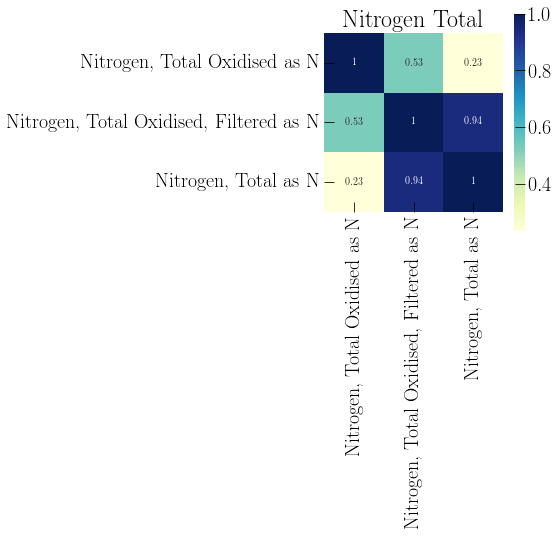

In [48]:
corrmat_NT = df_piv_out[NitrogenTotal_Name].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.heatmap(corrmat_NT, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Nitrogen Total");

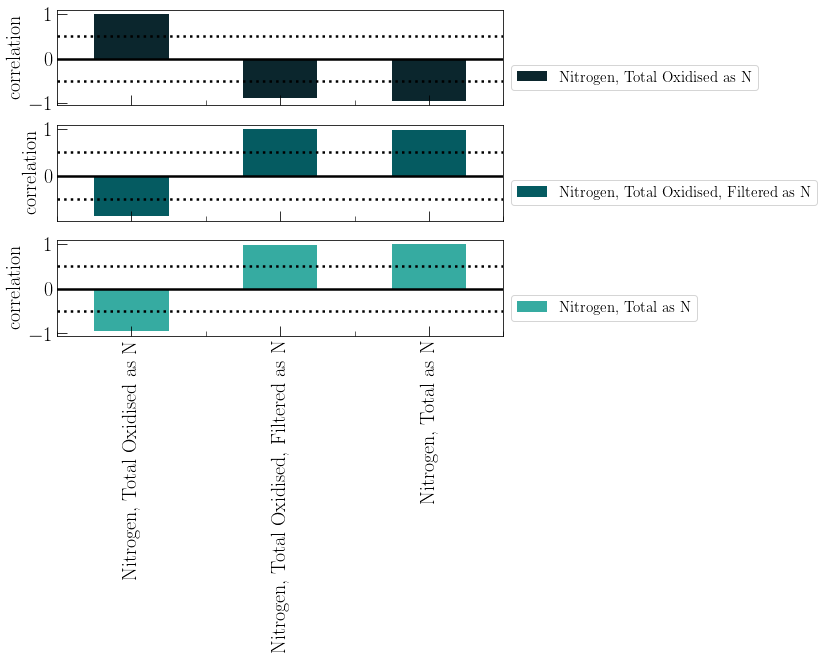

In [49]:
fig, ax = plt.subplots(nrows=len(NitrogenTotal_Name),ncols=1, sharex=True, figsize=(8,6))
for i, N in enumerate(NitrogenTotal_Name):
    corrmat_NT.corr()[N].plot.bar(ax = ax[i],  alpha=1, label=str(N), color = color_N[i])
    ax[i].legend(fontsize=15, bbox_to_anchor=(1,.5))
    ax[i].axhline(y=0, color="black")
    ax[i].axhline(y=0.5, color="black", linestyle=":")
    ax[i].axhline(y=-0.5, color="black", linestyle=":")
    ax[i].set_ylabel("correlation")

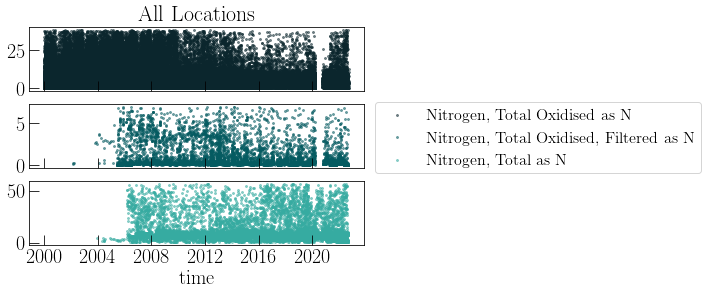

In [50]:
fig = plot_nutrientsdate(df_piv_out,NitrogenTotal_Name, "All Locations",\
          color_N, bbox_to_anchor_=(1.7, .65), figsize_ = (6,4), sct_kwargs = scatter_params)

In [51]:
df_piv_out[df_piv_out[NitrogenTotal_Name[0]].notna()&df_piv_out[NitrogenTotal_Name[1]].notna()][NitrogenTotal_Name]

Nitrogen, Total Oxidised as N  \
34414                            2.12   
35170                            4.72   
54178                            3.67   
54179                            3.59   
54180                            3.73   
54181                            2.79   
54182                            2.83   
54183                            2.18   
54184                            3.00   
54186                            2.76   
54187                            2.53   
54188                            2.87   
54189                            2.81   
54190                            2.90   
54191                            2.53   
54192                            1.66   
54193                            1.71   
54194                            1.23   
54195                            0.96   
54196                            1.60   
54197                            1.29   
54198                            2.11   
54199                            1.86   
54200                            2.42   
54201                            2.91   
54202                            3.32   
54203                            2.97   
54204                            2.45   
54205                            2.34   
54206                            1.89   
54207                            1.16   
54208                            1.21   
54209                            1.58   
54210                            2.13   
54211                            2.35   
54212                            3.19   
79016                            4.15   
79018                            2.87   
79022                            1.06   
79024                            2.43   
87076                           11.50   
87080                            1.24   
87083                            1.26   
87086                            1.57   
87088                            0.23   
87093                            0.25   
87103                            3.59   
87105                            0.97   
89702                            6.80   
89716                            5.57   
169380                           0.22   
169381                           0.33   
169411                           0.22   
169412                           0.23   

        Nitrogen, Total Oxidised, Filtered as N  Nitrogen, Total as N  
34414                                     0.380                   NaN  
35170                                     4.720                   NaN  
54178                                     2.450                  4.36  
54179                                     3.630                   NaN  
54180                                     3.610                   NaN  
54181                                     3.190                   NaN  
54182                                     2.820                  4.22  
54183                                     2.080                  2.68  
54184                                     2.960                  3.57  
54186                                     2.820                   NaN  
54187                                     2.600                   NaN  
54188                                     2.770                  3.89  
54189                                     2.860                  3.52  
54190                                     2.900                  3.48  
54191                                     2.290                  3.42  
54192                                     1.620                  2.83  
54193                                     1.770                  2.32  
54194                                     1.260                  1.75  
54195                                     0.890                  2.54  
54196                                     1.620                  2.25  
54197                                     1.320                  1.93  
54198                                     2.010                  3.31  
54199                                     1.890                  2.88  
54200                   

##### Again, it does not look like any of the nutrients have been switched off one for the other

#### Ammoniacal

Ammonia un-ionised as N [119][NH3 un-ion]

Ammoniacal Nitrogen as N [111][Ammonia(N)]

Ammoniacal Nitrogen, Filtered as N [9993] [NH3 filt N]

In [52]:
Ammoniacal_Name =  list(np.unique(df[df["determinand.notation"].isin([119,111,9993])]["determinand.definition"]))

Text(0.5, 1.0, 'Ammonia')

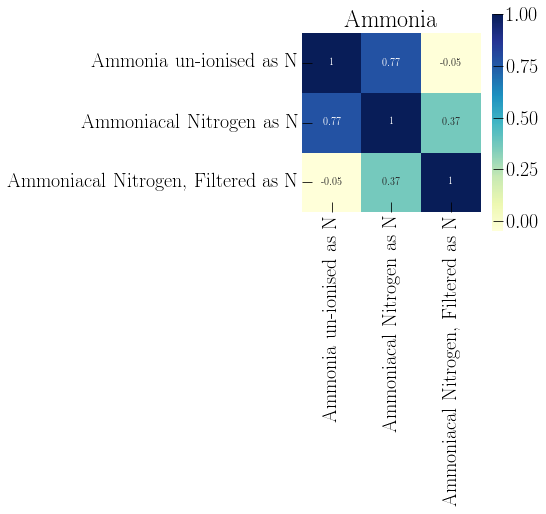

In [53]:
corrmat_A = df_piv_out[Ammoniacal_Name].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.heatmap(corrmat_A, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Ammonia")

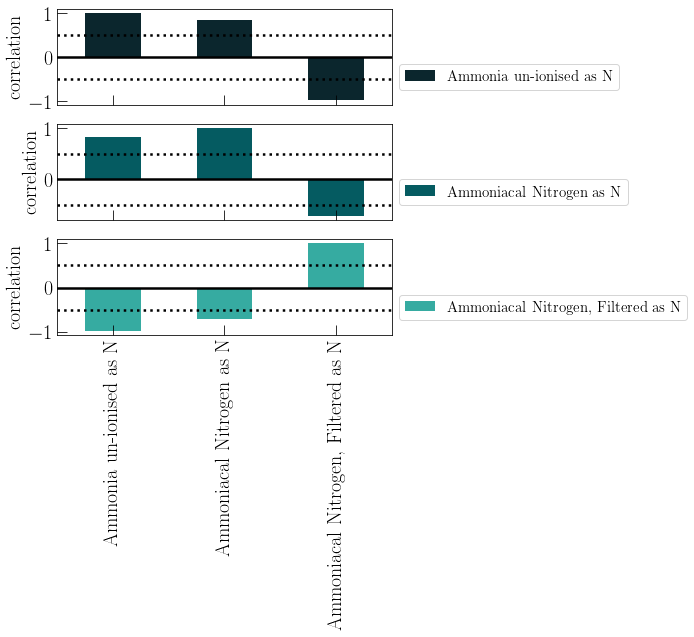

In [54]:
fig, ax = plt.subplots(nrows=len(Ammoniacal_Name),ncols=1, sharex=True, figsize=(6,6))
for i, N in enumerate(Ammoniacal_Name):
    corrmat_A.corr()[N].plot.bar(ax = ax[i],  alpha=1, label=str(N), color = color_N[i])
    ax[i].legend(fontsize=15, bbox_to_anchor=(1,.5))
    ax[i].axhline(y=0, color="black")
    ax[i].axhline(y=0.5, color="black", linestyle=":")
    ax[i].axhline(y=-0.5, color="black", linestyle=":")
    ax[i].set_ylabel("correlation")

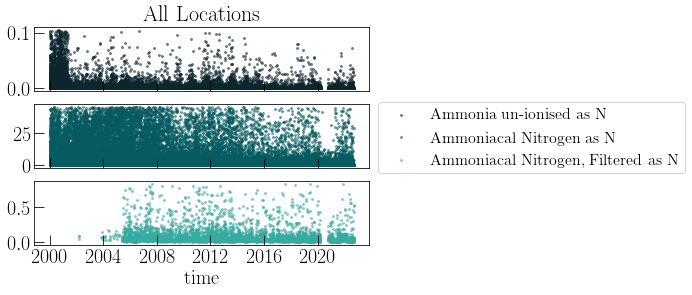

In [55]:
fig = plot_nutrientsdate(df_piv_out, \
          Ammoniacal_Name, "All Locations",\
          color_N, bbox_to_anchor_=(1.65, .65), figsize_ = (6,4), sct_kwargs = scatter_params)

In [56]:
df_piv_out[df_piv_out[Ammoniacal_Name[0]].notna()&df_piv_out[Ammoniacal_Name[1]].notna()&df_piv_out[Ammoniacal_Name[2]].notna()][Ammoniacal_Name]

Ammonia un-ionised as N  Ammoniacal Nitrogen as N  \
34414                   0.00035                     0.027   
87077                   0.00756                     0.482   
87080                   0.01300                     0.829   
87083                   0.00407                     0.465   
87084                   0.01680                     0.569   
87086                   0.02450                     0.827   
87089                   0.00808                     0.443   
87090                   0.01570                     0.501   
87093                   0.00545                     0.515   
87097                   0.00756                     0.516   
87099                   0.00373                     0.428   
87103                   0.00894                     0.720   
87105                   0.00661                     0.326   
87110                   0.01270                     0.458   
87116                   0.00435                     0.427   
89697                   0.01110                     0.588   
89699                   0.00980                     0.510   
89702                   0.00015                     0.063   
89704                   0.00798                     0.573   
89707                   0.00743                     0.515   
89710                   0.02370                     0.737   
89713                   0.00912                     0.473   
89716                   0.00029                     0.077   
200486                  0.00951                     0.561   

        Ammoniacal Nitrogen, Filtered as N  
34414                                0.028  
87077                                0.044  
87080                                0.163  
87083                                0.072  
87084                                0.030  
87086                                0.049  
87089                                0.041  
87090                                0.046  
87093                                0.078  
87097                                0.043  
87099                                0.029  
87103                                0.119  
87105                                0.087  
87110                                0.020  
87116                                0.013  
89697                                0.059  
89699                                0.042  
89702                                0.065  
89704                                0.060  
89707                                0.021  
89710                                0.027  
89713                                0.075  
89716                                0.067  
200486                               0.036

##### Again, it does not look like any of the nutrients have been switched off one for the other

#### Nitrogen

Nitrogen, Dissolved Inorganic : as N [4925][ N Dis Inorg]
    
Nitrogen, Kjeldahl as N [114][ N-Kjeldahl]

Nitrogen, Total Oxidised as N [116][N Oxidised]

Nitrogen, Total Oxidised, Filtered as N [9943][N Oxid Filt]

Nitrogen, Total as N [9686][Nitrogen - N]

In [57]:
NitrogenIn_names = list(np.unique(df[df["determinand.notation"].isin([4925,114, 116, 9943,9686])]["determinand.definition"]))

Text(0.5, 1.0, 'Nitrogen')

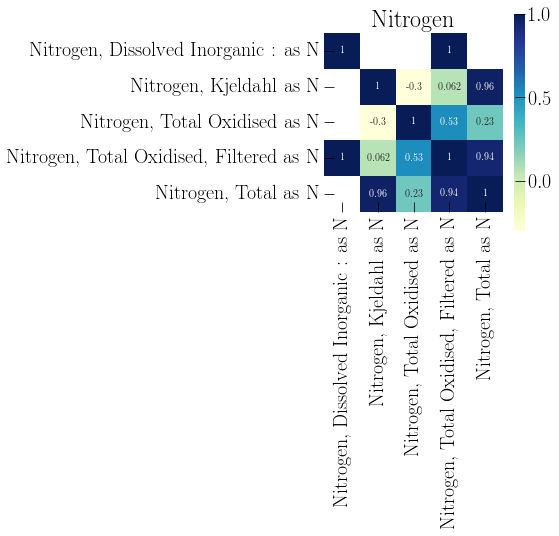

In [58]:
corrmat_NI = df_piv_out[NitrogenIn_names].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(4, 4))
fig = sns.heatmap(corrmat_NI, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Nitrogen")

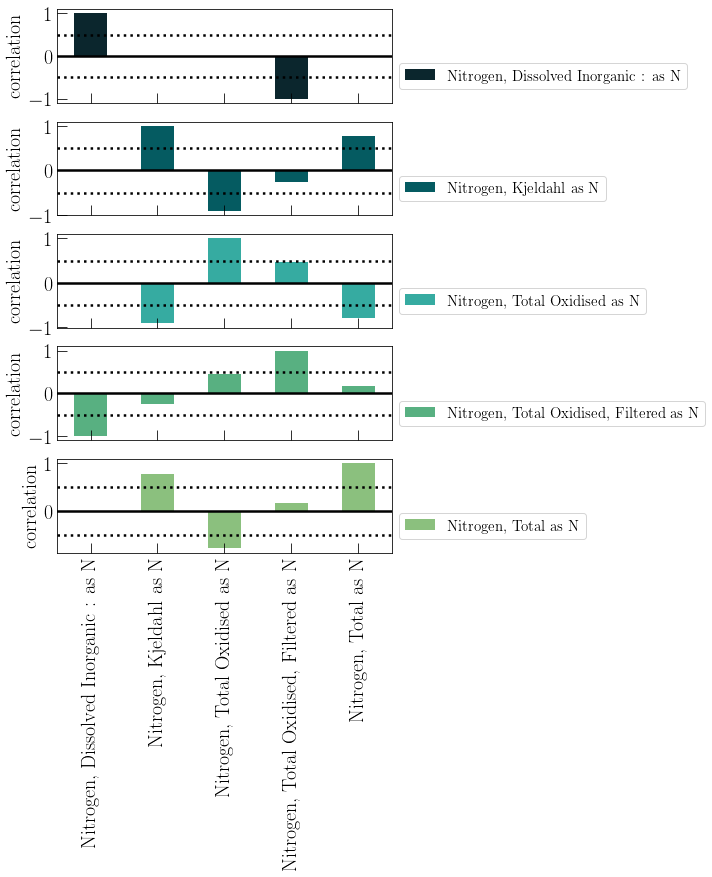

In [59]:
fig, ax = plt.subplots(nrows=len(NitrogenIn_names),ncols=1, sharex=True, figsize=(6,10))
for i, N in enumerate(NitrogenIn_names):
    corrmat_NI.corr()[N].plot.bar(ax = ax[i],  alpha=1, label=str(N), color = color_N[i])
    ax[i].legend(fontsize=15, bbox_to_anchor=(1,.5))
    ax[i].axhline(y=0, color="black")
    ax[i].axhline(y=0.5, color="black", linestyle=":")
    ax[i].axhline(y=-0.5, color="black", linestyle=":")
    ax[i].set_ylabel("correlation")

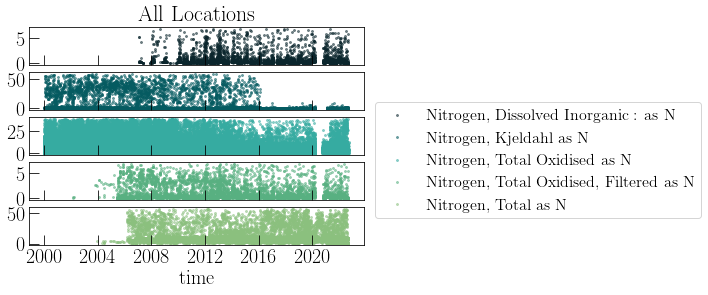

In [60]:
fig = plot_nutrientsdate(df_piv_out,NitrogenIn_names, "All Locations",\
          color_N, bbox_to_anchor_=(1.7, .65), figsize_ = (6,4), sct_kwargs = scatter_params)

In [61]:
df_piv_out[df_piv_out[NitrogenIn_names[0]].notna()&df_piv_out[NitrogenIn_names[1]].notna()]

Empty DataFrame
Columns: [sample.samplingPoint.notation, sample.samplingPoint.label, sample.sampledMaterialType.label, sample.samplingPoint.easting, sample.samplingPoint.northing, Date, Ammonia un-ionised as N, Ammoniacal Nitrogen as N, Ammoniacal Nitrogen, Filtered as N, Animal faeces, Strandline to waters edge, Bathing Water Profile : Algal Bloom, Bathing Water Profile : Animal Faeces, Bathing Water Profile : Dead Marine Life, Bathing Water Profile : Macroalgae, Bathing Water Profile : Oil and Tar, Bathing Water Profile : Other Litter (incl. plastics), Bathing Water: Plastics, Borehole : Depth to liquid :- {Ground level to liquid}, Borehole : Depth total, Metres below datum, Boron, Boiling water soluble : Dry Wt, Chlorophyll a + b, Depth relative to Chart Datum, Marine algae, Waters edge, Nitrate as N, Nitrate, Filtered as N, Nitrite as N, Nitrite, Filtered as N, Nitrogen, Dissolved Inorganic : as N, Nitrogen, Kjeldahl as N, Nitrogen, Total Oxidised as N, Nitrogen, Total Oxidised, Filtered as N, Nitrogen, Total as N, Orthophosphate, Filtered as P, Orthophosphate, reactive as P, Phosphorus, Total as P, River flow status, Salinity, Salinity : Calculated from Chloride, Salinity : In Situ, Salinity : Refractometer : Intertidal, Interstitial, Salinity, by Bench Salinometer, Salinity, by Conductivity, Sample Depth below surface, Secchi depth, Sewage debris, Temperature of Water, Time of high tide, Time of sampling relative to previous high water, Unusual Weather Waiver (WRA), Warning Sign - Short Term Bathing Water Pollution, Water Depth, Water Level Below top cover, Water level above OD, Weather : Abnormal, Weather : Cloud Cover, Weather : Precipitation, Weather : Rainfall : Coded, Weather : Sunshine : Coded, Weather : Temperature of Air, Weather : Wind Direction : Degrees, Weather : Wind Speed, Weather : Wind Speed : Beaufort Scale, year, month, season]
Index: []

[0 rows x 65 columns]

In [62]:
df_piv_out[df_piv_out[NitrogenIn_names[0]].notna()&df_piv_out[NitrogenIn_names[4]].notna()]

Empty DataFrame
Columns: [sample.samplingPoint.notation, sample.samplingPoint.label, sample.sampledMaterialType.label, sample.samplingPoint.easting, sample.samplingPoint.northing, Date, Ammonia un-ionised as N, Ammoniacal Nitrogen as N, Ammoniacal Nitrogen, Filtered as N, Animal faeces, Strandline to waters edge, Bathing Water Profile : Algal Bloom, Bathing Water Profile : Animal Faeces, Bathing Water Profile : Dead Marine Life, Bathing Water Profile : Macroalgae, Bathing Water Profile : Oil and Tar, Bathing Water Profile : Other Litter (incl. plastics), Bathing Water: Plastics, Borehole : Depth to liquid :- {Ground level to liquid}, Borehole : Depth total, Metres below datum, Boron, Boiling water soluble : Dry Wt, Chlorophyll a + b, Depth relative to Chart Datum, Marine algae, Waters edge, Nitrate as N, Nitrate, Filtered as N, Nitrite as N, Nitrite, Filtered as N, Nitrogen, Dissolved Inorganic : as N, Nitrogen, Kjeldahl as N, Nitrogen, Total Oxidised as N, Nitrogen, Total Oxidised, Filtered as N, Nitrogen, Total as N, Orthophosphate, Filtered as P, Orthophosphate, reactive as P, Phosphorus, Total as P, River flow status, Salinity, Salinity : Calculated from Chloride, Salinity : In Situ, Salinity : Refractometer : Intertidal, Interstitial, Salinity, by Bench Salinometer, Salinity, by Conductivity, Sample Depth below surface, Secchi depth, Sewage debris, Temperature of Water, Time of high tide, Time of sampling relative to previous high water, Unusual Weather Waiver (WRA), Warning Sign - Short Term Bathing Water Pollution, Water Depth, Water Level Below top cover, Water level above OD, Weather : Abnormal, Weather : Cloud Cover, Weather : Precipitation, Weather : Rainfall : Coded, Weather : Sunshine : Coded, Weather : Temperature of Air, Weather : Wind Direction : Degrees, Weather : Wind Speed, Weather : Wind Speed : Beaufort Scale, year, month, season]
Index: []

[0 rows x 65 columns]

#### We never have these pairs at the same time in the entire catalogue

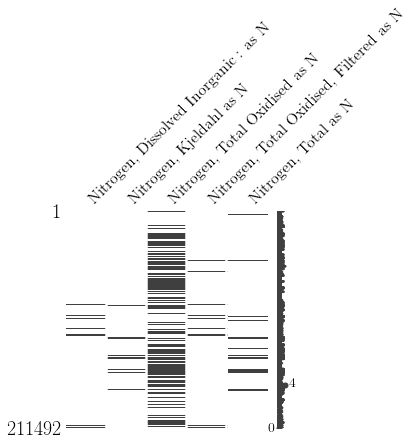

In [63]:
msno.matrix(df_piv_out[NitrogenIn_names], figsize=(4,4));

#### I do not think it is for any other reasons that absence of data collection

# 1) Location problem:

1) selecting area through names etc

2) dividing the locations analysed in seawater, estuarine water, freshwater and sewage

In [64]:
set(np.unique(df_piv_out["sample.sampledMaterialType.label"]))

{'ANY BIOTA',
 'ANY LEACHATE',
 'ANY NON-AQUEOUS LIQUID',
 'ANY SEWAGE',
 'ANY SEWAGE SLUDGE',
 'ANY SOLID/SEDIMENT - UNSPECIFIED',
 'ANY TRADE EFFLUENT',
 'ANY WATER',
 'CANAL WATER',
 'CERASTODERMA EDULE - COCKLE - WHOLE ANIMAL',
 'COASTAL / MARINE SEDIMENT',
 'COASTAL / MARINE SEDIMENT - <63UM FRACTION',
 'CRUDE SEWAGE',
 'ESTUARINE WATER',
 'ESTUARINE WATER AT HIGH TIDE',
 'ESTUARY SEDIMENT',
 'ESTUARY SEDIMENT - <63UM FRACTION',
 'ESTUARY SEDIMENT - INTER TIDAL',
 'ESTUARY SEDIMENT - INTER TIDAL - <63UM FRACTION',
 'ESTUARY SEDIMENT - SUB TIDAL',
 'FINAL SEWAGE EFFLUENT',
 'GROUNDWATER',
 'GROUNDWATER - PURGED/PUMPED/REFILLED',
 'MYTILUS EDULIS - MUSSEL - WHOLE ANIMAL',
 'OSTEREA EDULIS - NATIVE OYSTER - WHOLE ANIMAL',
 'POND / LAKE / RESERVOIR WATER',
 'PRECIPITATION',
 'RIVER / RUNNING SURFACE WATER',
 'RUNNING SURFACE WATER SEDIMENT',
 'RUNNING SURFACE WATER SEDIMENT - <63UM FRACTION',
 'SEA WATER',
 'STORM SEWER OVERFLOW DISCHARGE',
 'STORM TANK EFFLUENT',
 'SURFACE DRAINAGE',

In [65]:
df_piv_out.groupby(["sample.sampledMaterialType.label"]).count().sort_values(by="sample.samplingPoint.notation", ascending=False)["sample.samplingPoint.notation"]#.index.get_level_values("sample.sampledMaterialType.label")

sample.sampledMaterialType.label
RIVER / RUNNING SURFACE WATER                      86083
FINAL SEWAGE EFFLUENT                              51892
SEA WATER                                          32684
ESTUARINE WATER                                    14131
ANY TRADE EFFLUENT                                  9262
GROUNDWATER                                         4819
CRUDE SEWAGE                                        3418
POND / LAKE / RESERVOIR WATER                       2417
SURFACE DRAINAGE                                    2181
TRADE EFFLUENT - FRESHWATER RETURNED ABSTRACTED     1230
ANY SEWAGE                                           928
ANY WATER                                            667
UNCODED                                              477
CANAL WATER                                          415
COASTAL / MARINE SEDIMENT - <63UM FRACTION           169
STORM SEWER OVERFLOW DISCHARGE                       161
ESTUARINE WATER AT HIGH TIDE                         14

In [66]:
water_names = df_piv_out.groupby(["sample.sampledMaterialType.label"]).count().sort_values(by="sample.samplingPoint.notation", ascending=False)["sample.samplingPoint.notation"].index.get_level_values("sample.sampledMaterialType.label")

In [67]:
frequency = df_piv_out[["year", "sample.sampledMaterialType.label"]]

In [68]:
data = frequency.groupby(["year","sample.sampledMaterialType.label"]).size()


In [69]:
from matplotlib import cm


In [70]:
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(df_sub["sample.sampledMaterialType.label"]))))



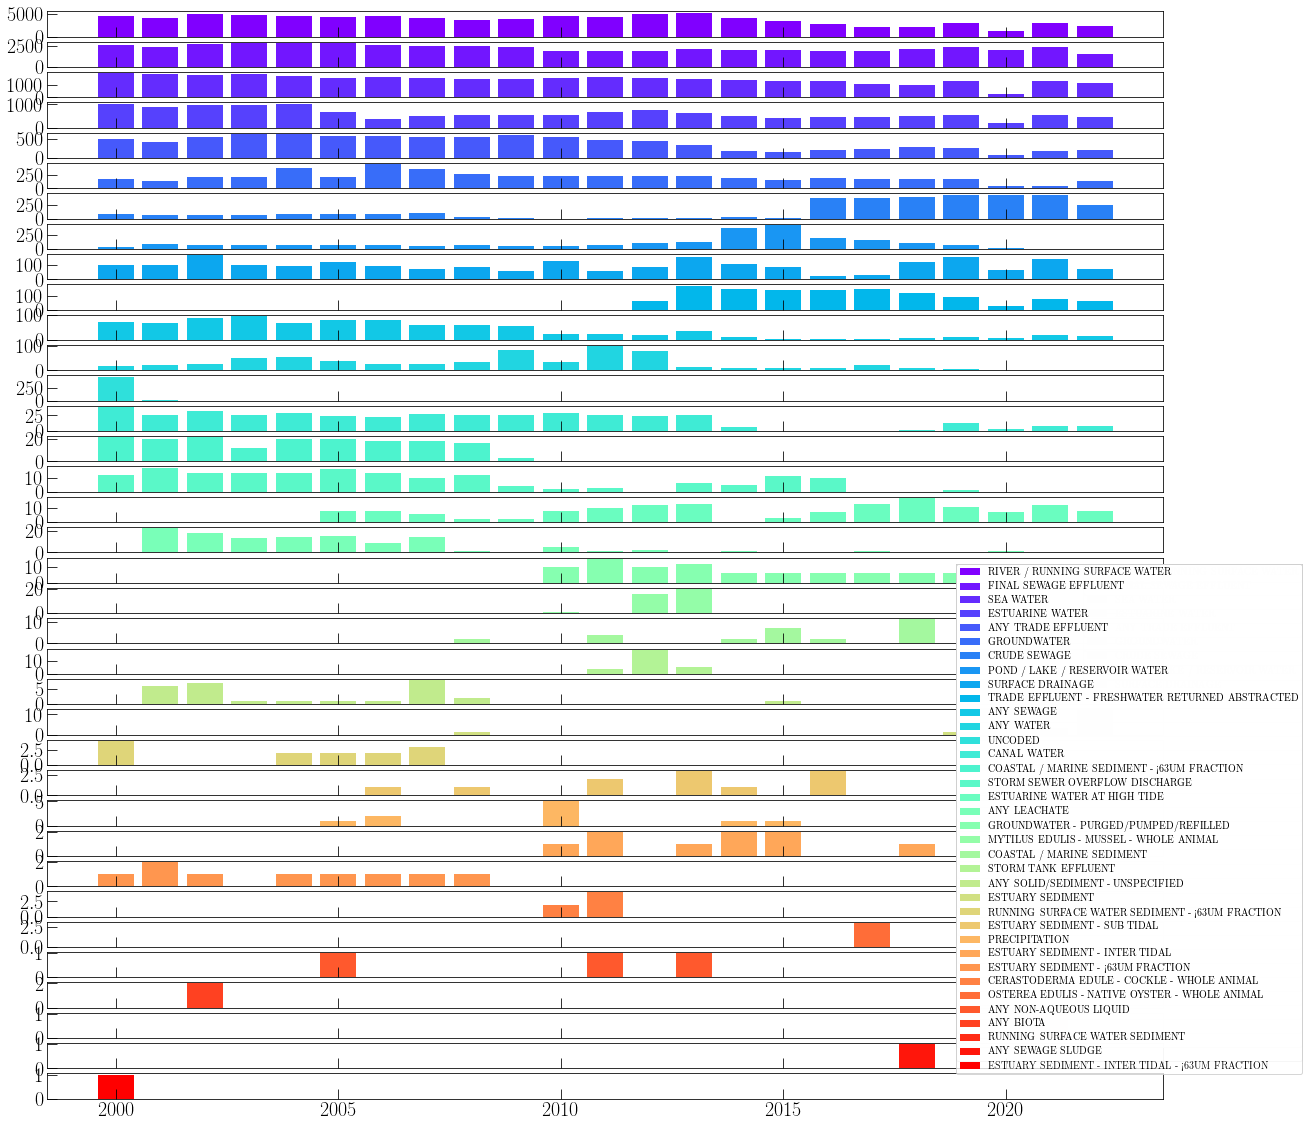

In [71]:
    fig, axes = plt.subplots(nrows=len(water_names),ncols=1, sharex=True, figsize=(20,20))
    for i in range(len(water_names)):
        axes[i].bar(data[(data.index.get_level_values("sample.sampledMaterialType.label") == \
                          water_names[i])].index.get_level_values('year'), \
                    data.loc[(data.index.get_level_values("sample.sampledMaterialType.label") ==\
                             water_names[i])].values, label = water_names[i], color=colors[i])
        fig.legend(bbox_to_anchor=(1., .5))
        fig.set_facecolor("w")

        plt.savefig('WaterType_frequency.png', bbox_inches='tight',  transparent=False)


### Let's keep a subset of the dataset where only the first 4 most frequent labels for the water

In [72]:
list(water_names[0:4])

['RIVER / RUNNING SURFACE WATER',
 'FINAL SEWAGE EFFLUENT',
 'SEA WATER',
 'ESTUARINE WATER']

In [73]:
df_water = df_piv_out[df_piv_out["sample.sampledMaterialType.label"].isin(list(water_names[0:4]))]

In [74]:
(np.shape(df_water)[0]/np.shape(df_piv_out)[0]) #almost 90% of the catalogue has these 4 label!

0.8737446333667467

### Reconstruct the Langstone situation just based on the water label

In [75]:
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame

 # Data from here https://www.opendoorlogistics.com/downloads/

In [76]:
uk_district = gpd.read_file('/home/nannil/WaterQuality/Distribution/Districts.shp')


PO_district_oi = ["PO1", "PO2", "PO3", "PO5", "PO4", "PO6", "PO9", "PO10", "PO11"]

PO_district = uk_district[(uk_district['name'].isin(PO_district_oi) )].geometry

PO_district = PO_district.to_crs(4326)

<AxesSubplot:>

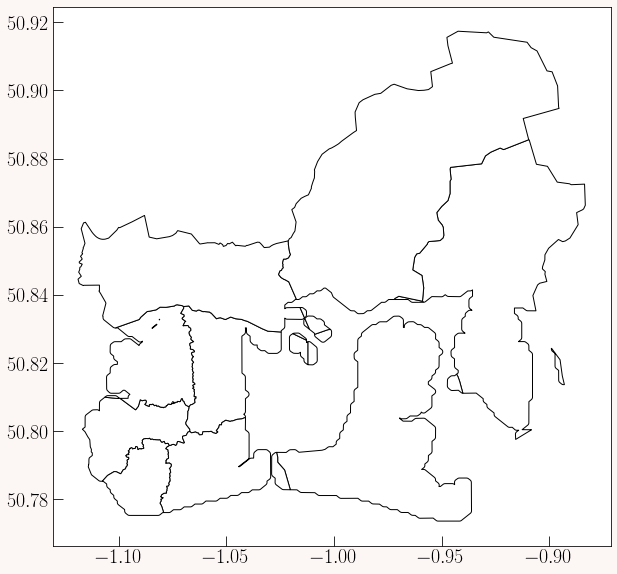

In [77]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 14)
PO_district.plot(ax = ax, color='white', edgecolor='black')

In [78]:
from shapely.geometry import Polygon


In [79]:
list_loc_langstone = ["SO-G0003493", "SO-G0016920","SO-G0003484","SO-G0016918","SO-G0015927",\
                              "SO-G0003468","SO-G0003467","SO-G0016921","SO-G0003473", "SO-G0003616", "SO-G0003625", "SO-G0003368", "SO-G0003508","SO-G0003484","SO-G0016873","SO-Y0003370"]

In [80]:
df_langstone_report = df_water[df_water["sample.samplingPoint.notation"].isin(list_loc_langstone)]

In [81]:
gdf_loc = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_langstone_report["sample.samplingPoint.easting"], \
                                                      df_langstone_report["sample.samplingPoint.northing"]), crs=27700)

In [82]:
gdf_loc = gdf_loc.to_crs(4326)

<AxesSubplot:>

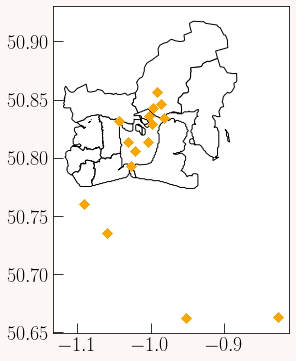

In [83]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(6, 6)

PO_district.plot(ax = ax, color='white', edgecolor='black')

gdf_loc.plot(ax=ax, color='orange', markersize=35, marker="D")


In [84]:
df_fw = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[0]]
df_sew = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[1]]
df_ocean = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[2]]
df_est = df_langstone_report[df_langstone_report["sample.sampledMaterialType.label"]==water_names[3]]

In [85]:
gdf_freshwater = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_fw["sample.samplingPoint.easting"], \
                                                      df_fw["sample.samplingPoint.northing"]), crs=27700)

In [86]:
gdf_freshwater = gdf_freshwater.to_crs(4326)

In [87]:
gdf_sewage = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_sew["sample.samplingPoint.easting"], \
                                                      df_sew["sample.samplingPoint.northing"]), crs=27700)

In [88]:
gdf_sewage = gdf_sewage.to_crs(4326)

In [89]:
gdf_ocean = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_ocean["sample.samplingPoint.easting"], \
                                                      df_ocean["sample.samplingPoint.northing"]), crs=27700)

In [90]:
gdf_ocean = gdf_ocean.to_crs(4326)

In [91]:
gdf_estuarine = gpd.GeoDataFrame(geometry=gpd.points_from_xy(df_est["sample.samplingPoint.easting"], \
                                                      df_est["sample.samplingPoint.northing"]), crs=27700)

In [92]:
gdf_estuarine = gdf_estuarine.to_crs(4326)

<AxesSubplot:>

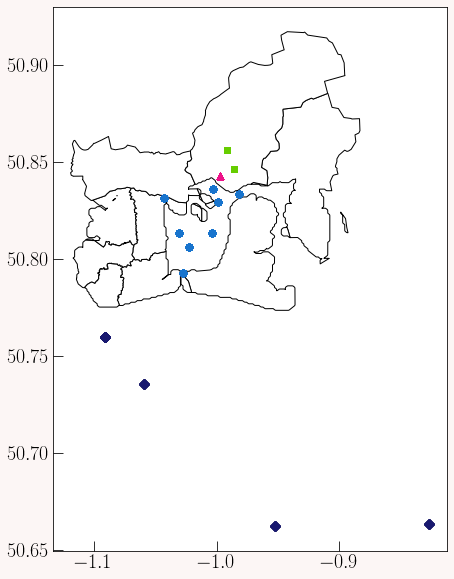

In [93]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 10)

PO_district.plot(ax = ax, color='white', edgecolor='black')

gdf_freshwater.plot(ax=ax, color='#66CD00', markersize=40, marker="s")
gdf_sewage.plot(ax=ax, color='#EE1289', markersize=40, marker="^")
gdf_estuarine.plot(ax=ax, color='#1874CD', markersize=40, marker="o")
gdf_ocean.plot(ax=ax, color='#191970', markersize=40, marker="D")


## DATA ABOUT RIVERS FROM https://www.ordnancesurvey.co.uk/business-government/products/open-map-rivers

In [94]:
rivers = gpd.read_file('/home/nannil/WaterQuality/data/HydroNode.shp')


In [95]:
rivers_course = gpd.read_file('/home/nannil/WaterQuality/data/WatercourseLink.shp')


In [96]:
rivers = rivers.to_crs(4326)

rivers_course = rivers_course.to_crs(4326)

### Let's consider the rivers and their nodes in the UK

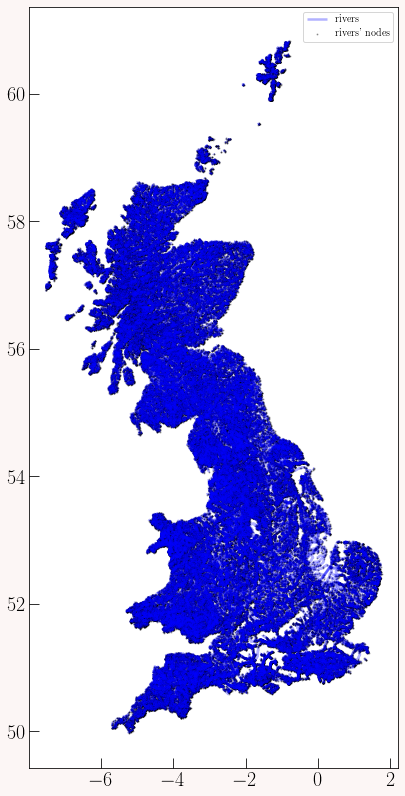

In [97]:

fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 14)
rivers_course.plot(ax = ax, color='blue', markersize=1, alpha=0.3, label="rivers")
rivers.plot(ax = ax, color='black', markersize=1, alpha=0.3, label="rivers' nodes")
plt.legend()
plt.show()

### We can select the rivers in our area of interest

In [98]:
polygon_geom = Polygon(gdf_loc.envelope)
crs = 'epsg:4326'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]).convex_hull   



In [99]:
mask_location = np.where(rivers.geometry.within(polygon.iloc[0])==True)
mask_location_course = (np.where(rivers_course.geometry.intersects(polygon.iloc[0])==True))



<AxesSubplot:>

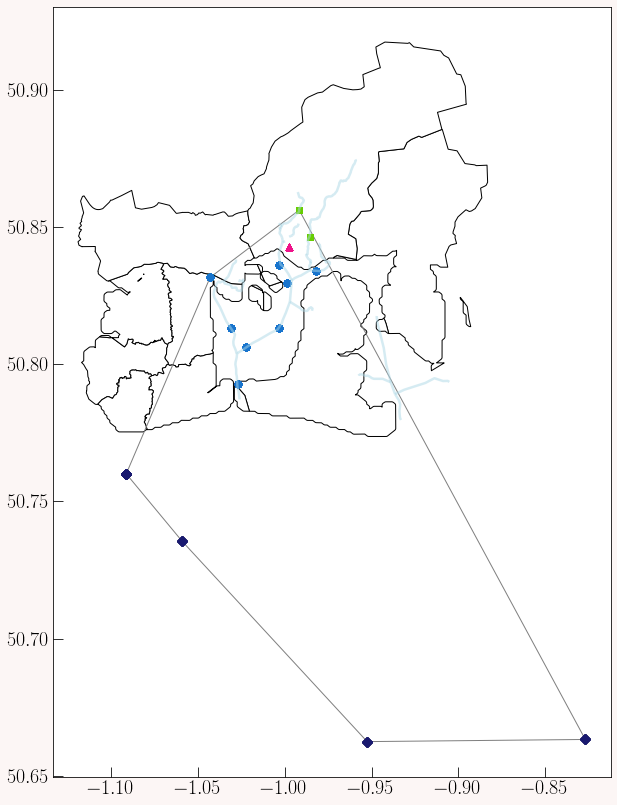

In [100]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(10, 20)

PO_district.plot(ax = ax, color='white', edgecolor='black')
polygon.plot(ax = ax, color='None', edgecolor='grey')

rivers_course.iloc[mask_location_course].plot(ax = ax, color='lightblue', markersize=10, alpha=0.5)
#rivers.iloc[mask_location].plot(ax = ax, color='white', edgecolor="black", markersize=40, alpha=1, marker="X")

gdf_freshwater.plot(ax=ax, color='#66CD00', markersize=40, marker="s")
gdf_sewage.plot(ax=ax, color='#EE1289', markersize=40, marker="^")
gdf_estuarine.plot(ax=ax, color='#1874CD', markersize=40, marker="o")
gdf_ocean.plot(ax=ax, color='#191970', markersize=40, marker="D")


### Check if locations are interchangable:

1) they have the same label for the water

2) they are along the same river

3) in the river, they must be in between the same two nodes

In [101]:
lang_riv = rivers_course.iloc[mask_location_course]

In [102]:
gdf_fw_buff = gdf_freshwater.copy()
gdf_fw_buff['geometry'] =  gdf_freshwater.to_crs(4326).geometry.buffer(0.0045)
# is a radius in lat-long!!!!

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


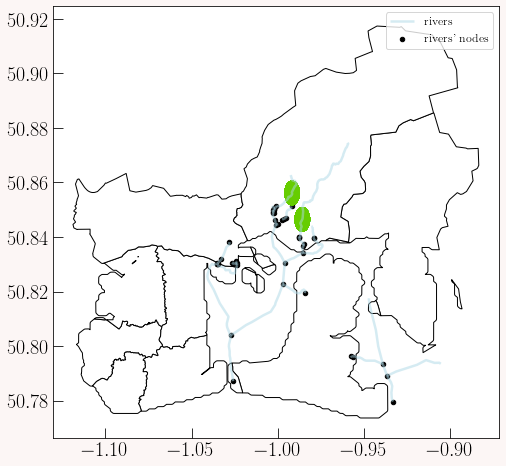

In [103]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(8, 8)

PO_district.plot(ax = ax, color='white', edgecolor='black')

rivers_course.iloc[mask_location_course].plot(ax = ax, color='lightblue', markersize=10, alpha=0.5, label="rivers")
rivers.iloc[mask_location].plot(ax = ax, color='black', markersize=20, alpha=1, label="rivers' nodes")
gdf_fw_buff.plot(ax=ax, color='#66CD00', label = "freshwater")
plt.legend(fontsize=12)



plt.show()

In [104]:
join_fw = gpd.sjoin(gdf_fw_buff, lang_riv, how = 'inner', op ='intersects')


/home/nannil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [105]:
#colors_new = cm.Spectral(np.linspace(0, 1, len(np.unique(join["index_right"].values))))
colors_new = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

### Check if locations are in the same river between the same nodes

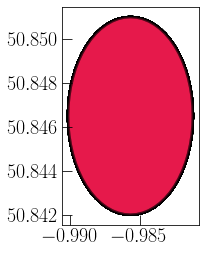

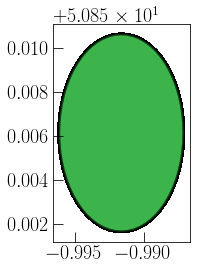

In [106]:
for i in range(len(np.unique(join_fw["index_right"].values))):
    ax = gdf_fw_buff.iloc[join_fw[join_fw["index_right"].values == np.unique(join_fw["index_right"].values)[i]].index]\
    .plot( facecolor=colors_new[i], edgecolor="black", linewidth=2.5, markersize=10, alpha =0.5, \
         label=str(np.unique(df_fw.iloc[join_fw[join_fw["index_right"].values==np.unique(join_fw["index_right"].values)[i]].index]["sample.samplingPoint.notation"])))


plt.show()

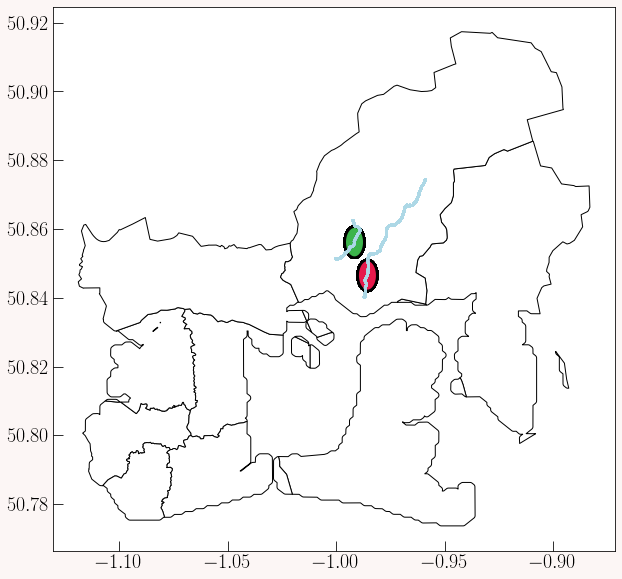

In [107]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 10)

PO_district.plot(ax = ax, color='white', edgecolor='black')


for i in range(len(np.unique(join_fw["index_right"].values))):
    lang_riv.loc[join_fw[join_fw["index_right"].values==np.unique(join_fw["index_right"].values)[i]]["index_right"]].plot(ax = ax, color='lightblue', markersize=20, alpha=1)
    gdf_fw_buff.iloc[join_fw[join_fw["index_right"].values == np.unique(join_fw["index_right"].values)[i]].index]\
    .plot(ax=ax,  facecolor=colors_new[i], edgecolor="black", linewidth=2.5)
    
    
    


In [108]:
gdf_es_buff = gdf_estuarine.copy()
gdf_es_buff['geometry'] =  gdf_estuarine.geometry.geometry.buffer(0.005)
# is a radius in lat-long!!!!

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


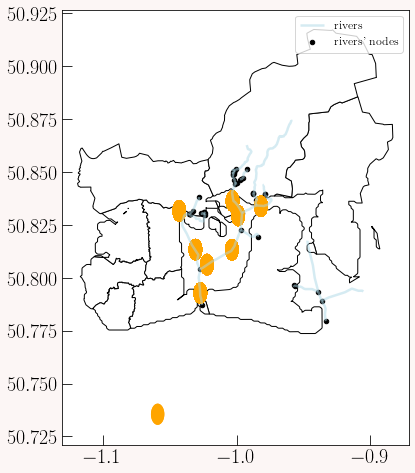

In [109]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(8, 8)

PO_district.plot(ax = ax, color='white', edgecolor='black')

rivers_course.iloc[mask_location_course].plot(ax = ax, color='lightblue', markersize=10, alpha=0.5, label="rivers")
rivers.iloc[mask_location].plot(ax = ax, color='black', markersize=20, alpha=1, label="rivers' nodes")
gdf_es_buff.plot(ax=ax, color='orange')

plt.legend(fontsize=12)



plt.show()

In [110]:
join = gpd.sjoin(gdf_es_buff, lang_riv, how = 'inner', op ='intersects')


/home/nannil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [111]:
#colors_new = cm.Spectral(np.linspace(0, 1, len(np.unique(join["index_right"].values))))
colors_new = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

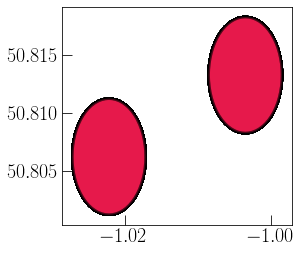

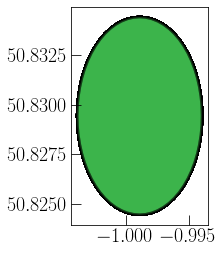

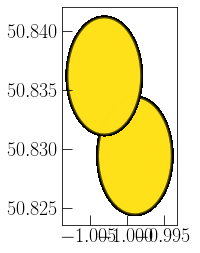

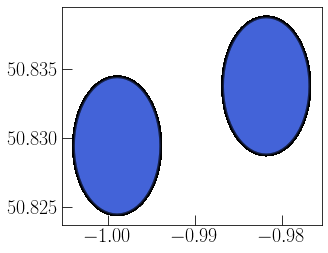

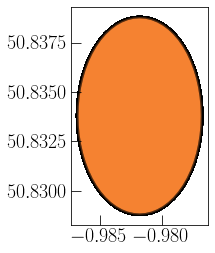

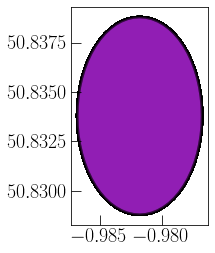

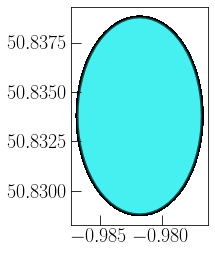

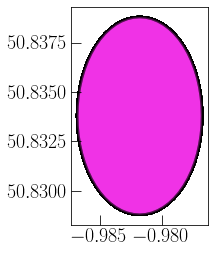

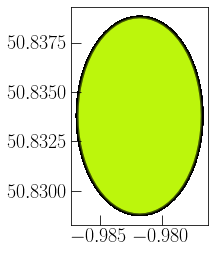

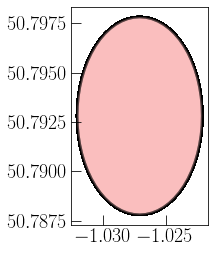

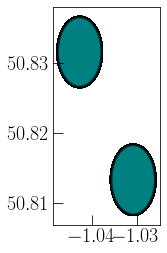

In [112]:
for i in range(len(np.unique(join["index_right"].values))):
    ax = gdf_es_buff.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]\
    .plot( facecolor=colors_new[i], edgecolor="black", linewidth=2.5, markersize=10, alpha =0.5)

plt.show()

In [113]:
for i in range(len(np.unique(join["index_right"].values))):
    if len(np.unique(df_est.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]["sample.samplingPoint.notation"]))>1:
        print(np.unique(df_est.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]["sample.samplingPoint.notation"]))

['SO-G0015927' 'SO-G0016920']
['SO-G0003468' 'SO-G0016921']
['SO-G0003467' 'SO-G0003468']
['SO-G0003484' 'SO-G0016918']


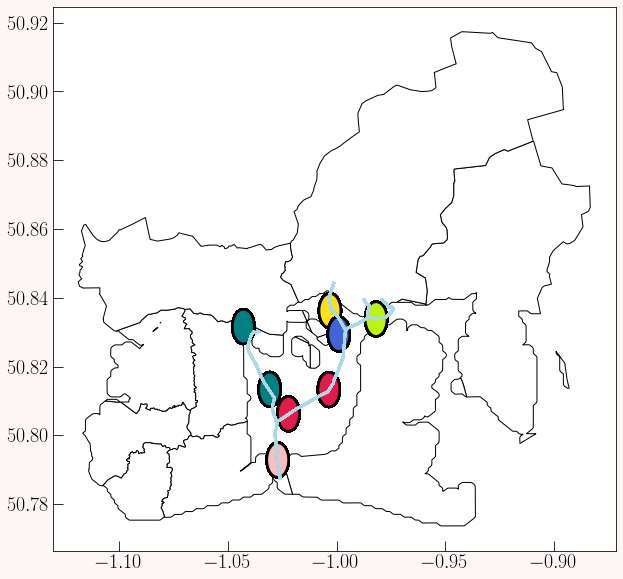

In [114]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 10)

PO_district.plot(ax = ax, color='white', edgecolor='black')


for i in range(len(np.unique(join["index_right"].values))):
    lang_riv.loc[join[join["index_right"].values==np.unique(join["index_right"].values)[i]]["index_right"]].plot(ax = ax, color='lightblue', markersize=20, alpha=1)
    gdf_es_buff.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]\
    .plot(ax=ax,  facecolor=colors_new[i], edgecolor="black", linewidth=2.5)
    
    

If the points are bigger and are in between two nodes, we have couples in which one of the elements is repeated

In [115]:
gdf_es_buff = gdf_estuarine.copy()
gdf_es_buff['geometry'] =  gdf_estuarine.geometry.geometry.buffer(0.003)
# is a radius in lat-long!!!!

/home/nannil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


In [116]:
join = gpd.sjoin(gdf_es_buff, lang_riv, how = 'inner', op ='intersects')


/home/nannil/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3472: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if (await self.run_code(code, result,  async_=asy)):


In [117]:
#colors_new = cm.Spectral(np.linspace(0, 1, len(np.unique(join["index_right"].values))))
colors_new = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', '#000075', '#808080']

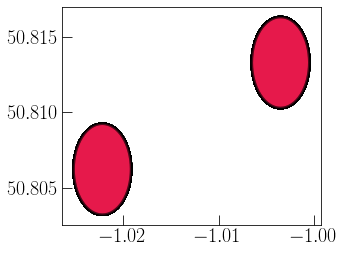

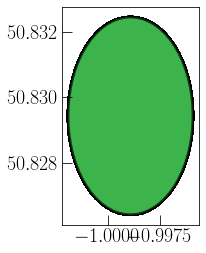

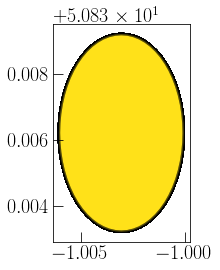

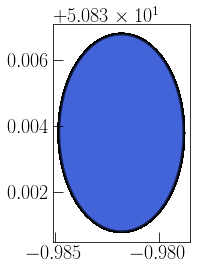

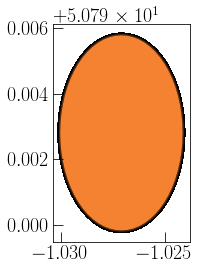

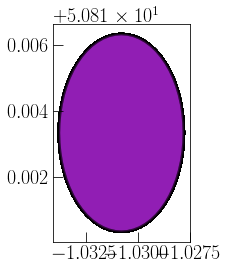

In [118]:
for i in range(len(np.unique(join["index_right"].values))):
    ax = gdf_es_buff.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]\
    .plot( facecolor=colors_new[i], edgecolor="black", linewidth=2.5, markersize=10, alpha =0.5)

plt.show()

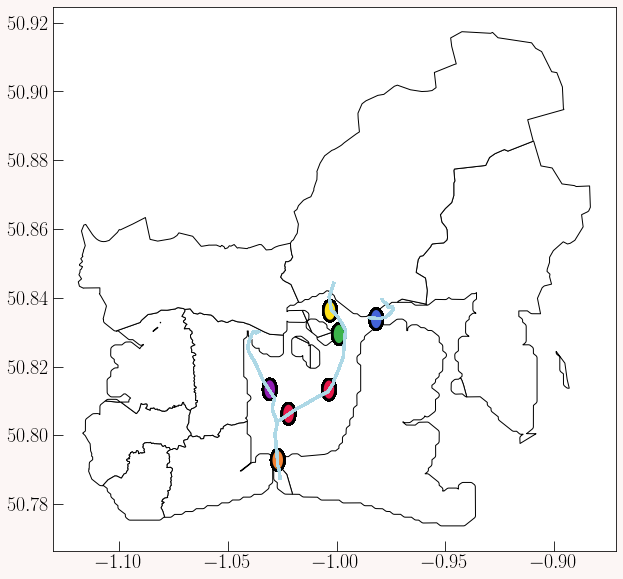

In [119]:
fig, ax = plt.subplots(facecolor='#FCF6F5FF')
fig.set_size_inches(15, 10)

PO_district.plot(ax = ax, color='white', edgecolor='black')


for i in range(len(np.unique(join["index_right"].values))):
    lang_riv.loc[join[join["index_right"].values==np.unique(join["index_right"].values)[i]]["index_right"]].plot(ax = ax, color='lightblue', markersize=20, alpha=1)
    gdf_es_buff.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]\
    .plot(ax=ax,  facecolor=colors_new[i], edgecolor="black", linewidth=2.5)
    
    
    


In [120]:
same_node = []
for i in range(len(np.unique(join["index_right"].values))):
    if len(np.unique(df_est.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]["sample.samplingPoint.notation"]))>1:
        same_node.append(np.unique(df_est.iloc[join[join["index_right"].values == np.unique(join["index_right"].values)[i]].index]["sample.samplingPoint.notation"]))

In [121]:
same_node

[array(['SO-G0015927', 'SO-G0016920'], dtype=object)]

# 2) Analyising the nutrients in the  Area

#### a) Time evolution of the nitrogen based nutrients

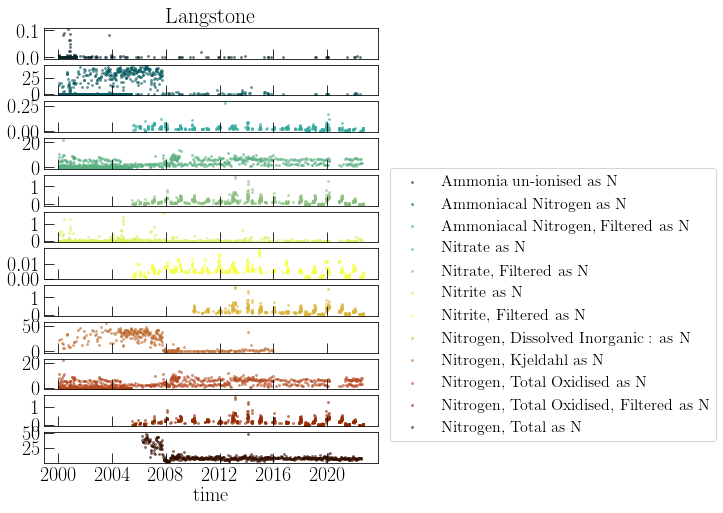

In [122]:
fig = plot_nutrientsdate(df_langstone_report, list(np.unique(df[df["determinand.notation"].isin(nutrients_N)]["determinand.definition"])) \
          , "Langstone",\
          color_N, bbox_to_anchor_=(1.7, .65), figsize_ = (6,8), sct_kwargs = scatter_params)

Text(0.5, 1.0, 'Nitrogen based Nutrients')

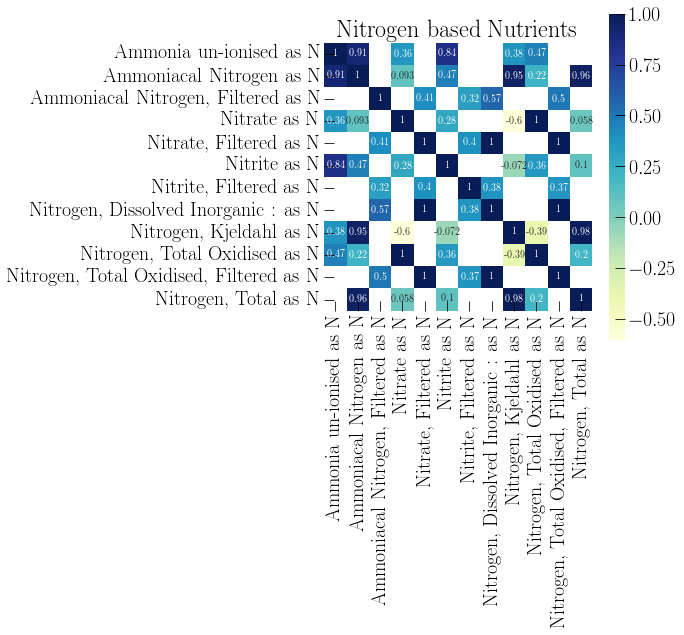

In [123]:
corrmat_lang = df_langstone_report[Nutrients_N_names].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.heatmap(corrmat_lang, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Nitrogen based Nutrients")

the white blocks show the determinands are never studied at the same time:

In [124]:
df_langstone_report[df_langstone_report[Nutrients_N_names[0]].notna()&df_langstone_report[Nutrients_N_names[2]].notna()]

Empty DataFrame
Columns: [sample.samplingPoint.notation, sample.samplingPoint.label, sample.sampledMaterialType.label, sample.samplingPoint.easting, sample.samplingPoint.northing, Date, Ammonia un-ionised as N, Ammoniacal Nitrogen as N, Ammoniacal Nitrogen, Filtered as N, Animal faeces, Strandline to waters edge, Bathing Water Profile : Algal Bloom, Bathing Water Profile : Animal Faeces, Bathing Water Profile : Dead Marine Life, Bathing Water Profile : Macroalgae, Bathing Water Profile : Oil and Tar, Bathing Water Profile : Other Litter (incl. plastics), Bathing Water: Plastics, Borehole : Depth to liquid :- {Ground level to liquid}, Borehole : Depth total, Metres below datum, Boron, Boiling water soluble : Dry Wt, Chlorophyll a + b, Depth relative to Chart Datum, Marine algae, Waters edge, Nitrate as N, Nitrate, Filtered as N, Nitrite as N, Nitrite, Filtered as N, Nitrogen, Dissolved Inorganic : as N, Nitrogen, Kjeldahl as N, Nitrogen, Total Oxidised as N, Nitrogen, Total Oxidised, Filtered as N, Nitrogen, Total as N, Orthophosphate, Filtered as P, Orthophosphate, reactive as P, Phosphorus, Total as P, River flow status, Salinity, Salinity : Calculated from Chloride, Salinity : In Situ, Salinity : Refractometer : Intertidal, Interstitial, Salinity, by Bench Salinometer, Salinity, by Conductivity, Sample Depth below surface, Secchi depth, Sewage debris, Temperature of Water, Time of high tide, Time of sampling relative to previous high water, Unusual Weather Waiver (WRA), Warning Sign - Short Term Bathing Water Pollution, Water Depth, Water Level Below top cover, Water level above OD, Weather : Abnormal, Weather : Cloud Cover, Weather : Precipitation, Weather : Rainfall : Coded, Weather : Sunshine : Coded, Weather : Temperature of Air, Weather : Wind Direction : Degrees, Weather : Wind Speed, Weather : Wind Speed : Beaufort Scale, year, month, season]
Index: []

[0 rows x 65 columns]

## Which nutrients to consider for DAIN?

### Dain = sum of ammonia (N) and total oxidized N

#### Dain = [119 + 111 +9993] + [116+9943]

## DAIP
Orthophosphate results were used
as a direct measure of dissolved available inorganic phosphorus (DAIP).

Orthophosphate, Filtered as P [9856]

Orthophosphate, reactive as P [180]

In [125]:
DAIN_names = list(np.unique(df[df["determinand.notation"].isin([119, 111, 9993,116,9943])]["determinand.definition"]))

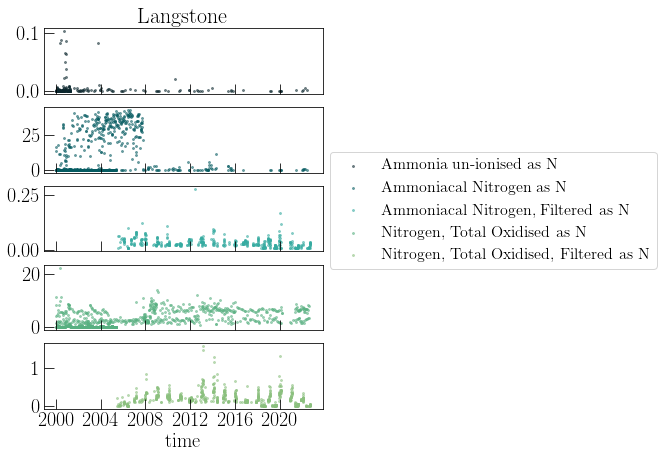

In [126]:
fig = plot_nutrientsdate(df_langstone_report, DAIN_names \
          , "Langstone",\
          color_N, bbox_to_anchor_=(1.85, .65), figsize_ = (5,7), sct_kwargs = scatter_params)

Text(0.5, 1.0, 'Nitrogen based Nutrients')

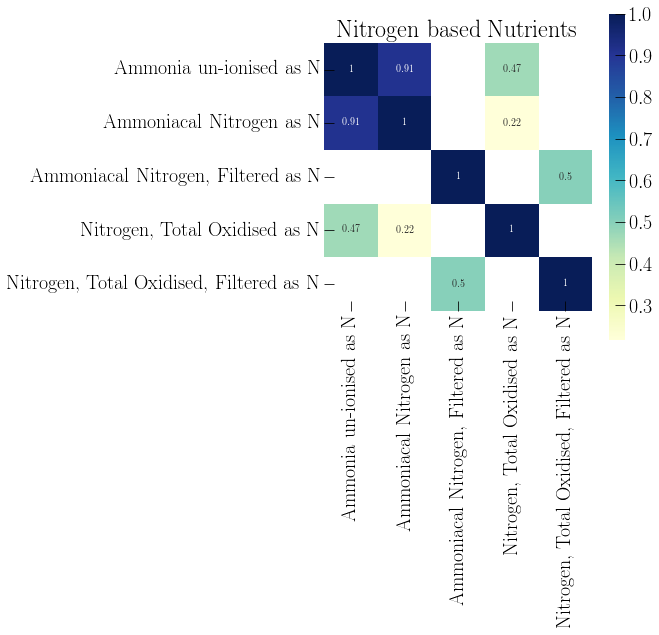

In [127]:
corrmat_lang = df_langstone_report[DAIN_names].corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.heatmap(corrmat_lang, vmax=1, square=True, cmap="YlGnBu",  annot=True);

plt.title("Nitrogen based Nutrients")

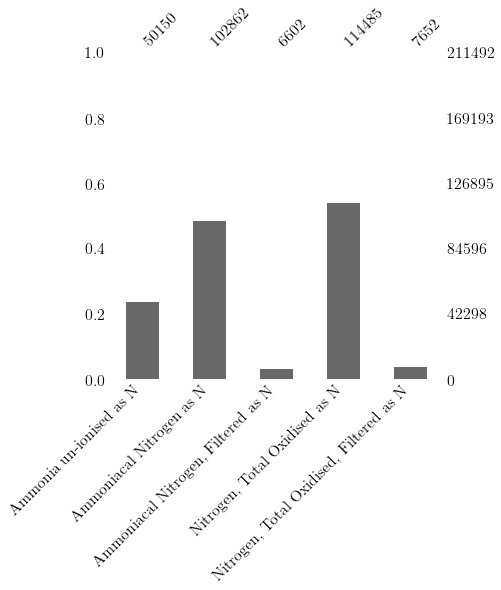

In [128]:
msno.bar(df_piv_out[DAIN_names], figsize=(6,6));

In [129]:
DAIP_names = list(np.unique(df[df["determinand.notation"].isin([180, 9856])]["determinand.definition"]))

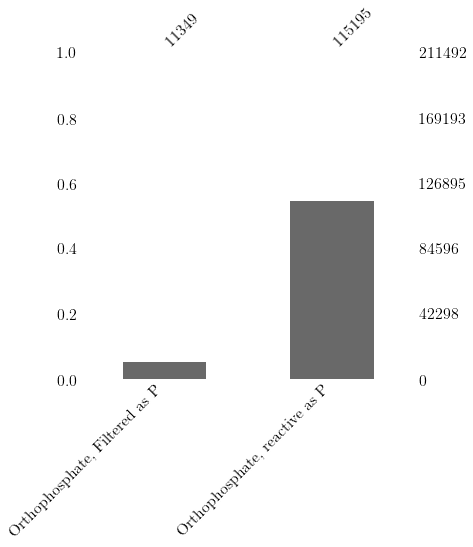

In [130]:
msno.bar(df_piv_out[DAIP_names], figsize=(6,6));

### Figure 3 in report:


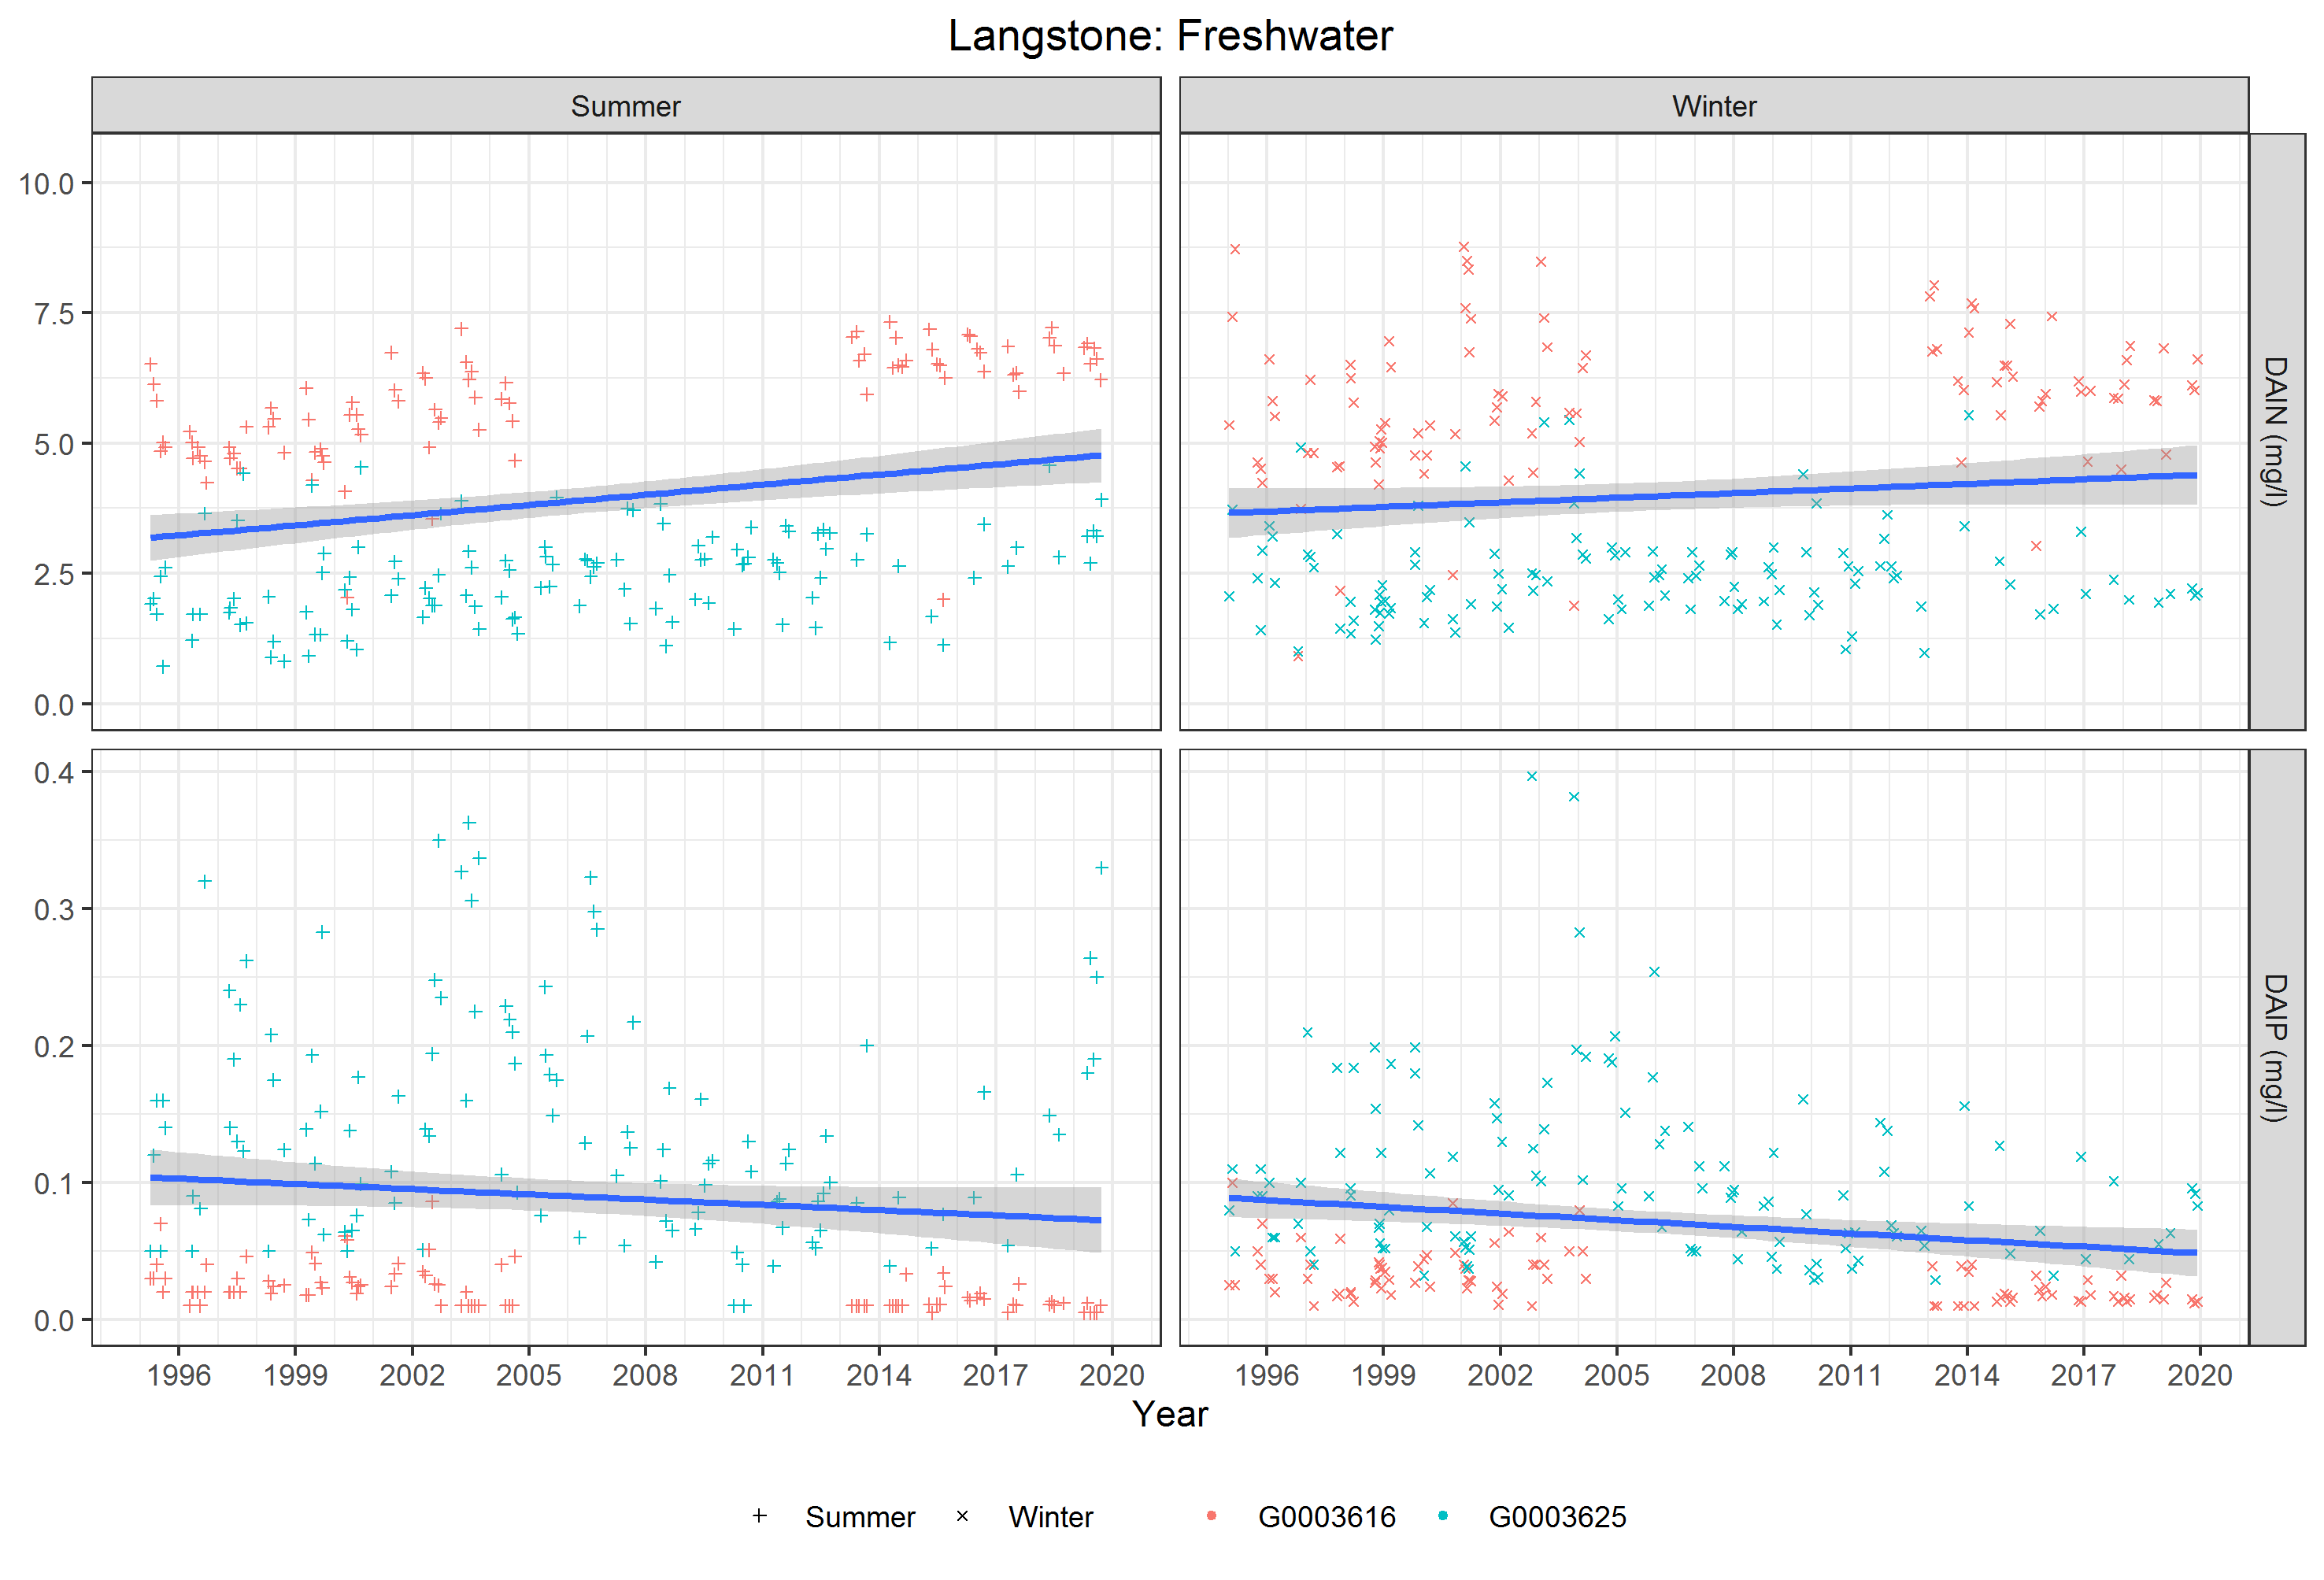

In [131]:
fw_notation = np.unique(df_fw["sample.samplingPoint.notation"])

Text(0, 0.5, 'DAIP (mg/l)')

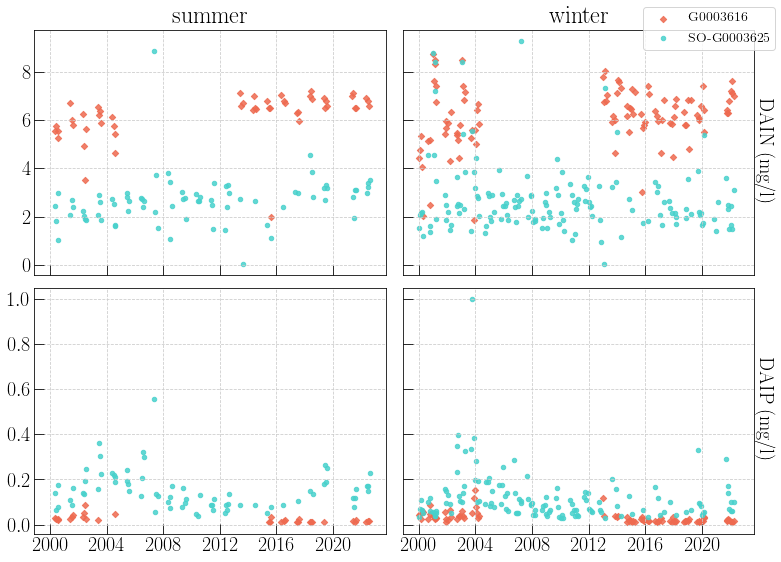

In [132]:
fig, axes = plt.subplots(nrows=2,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

axes[0,0].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==0)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                 label="G0003616", marker="D")
axes[0,0].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==0)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#48D1CC", alpha=0.85,\
                 label=str(fw_notation[1]))

axes[0,0].set_title("summer")

axes[0,1].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==1)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")

axes[0,1].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==1)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#48D1CC", alpha=0.85,\
                 )
axes[0,1].set_title("winter")


axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')


axes[1,0].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==0)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")
axes[1,0].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==0)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#48D1CC", alpha=0.85,\
                 )

axes[1,1].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==1)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[0])&(df_fw["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")

axes[1,1].scatter(df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==1)]["Date"], \
                  df_fw[(df_fw["sample.samplingPoint.notation"]==fw_notation[1])&(df_fw["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#48D1CC", alpha=0.85,\
                 )





axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
fig.legend(fontsize=14)

axes[0, 1].yaxis.set_label_position("right")
axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)


#### For a while 3616 was not sampled

#### We cannot use the other freshwater locations as they are not along the same river and in between the same river nodes


### Figure 4 in report:



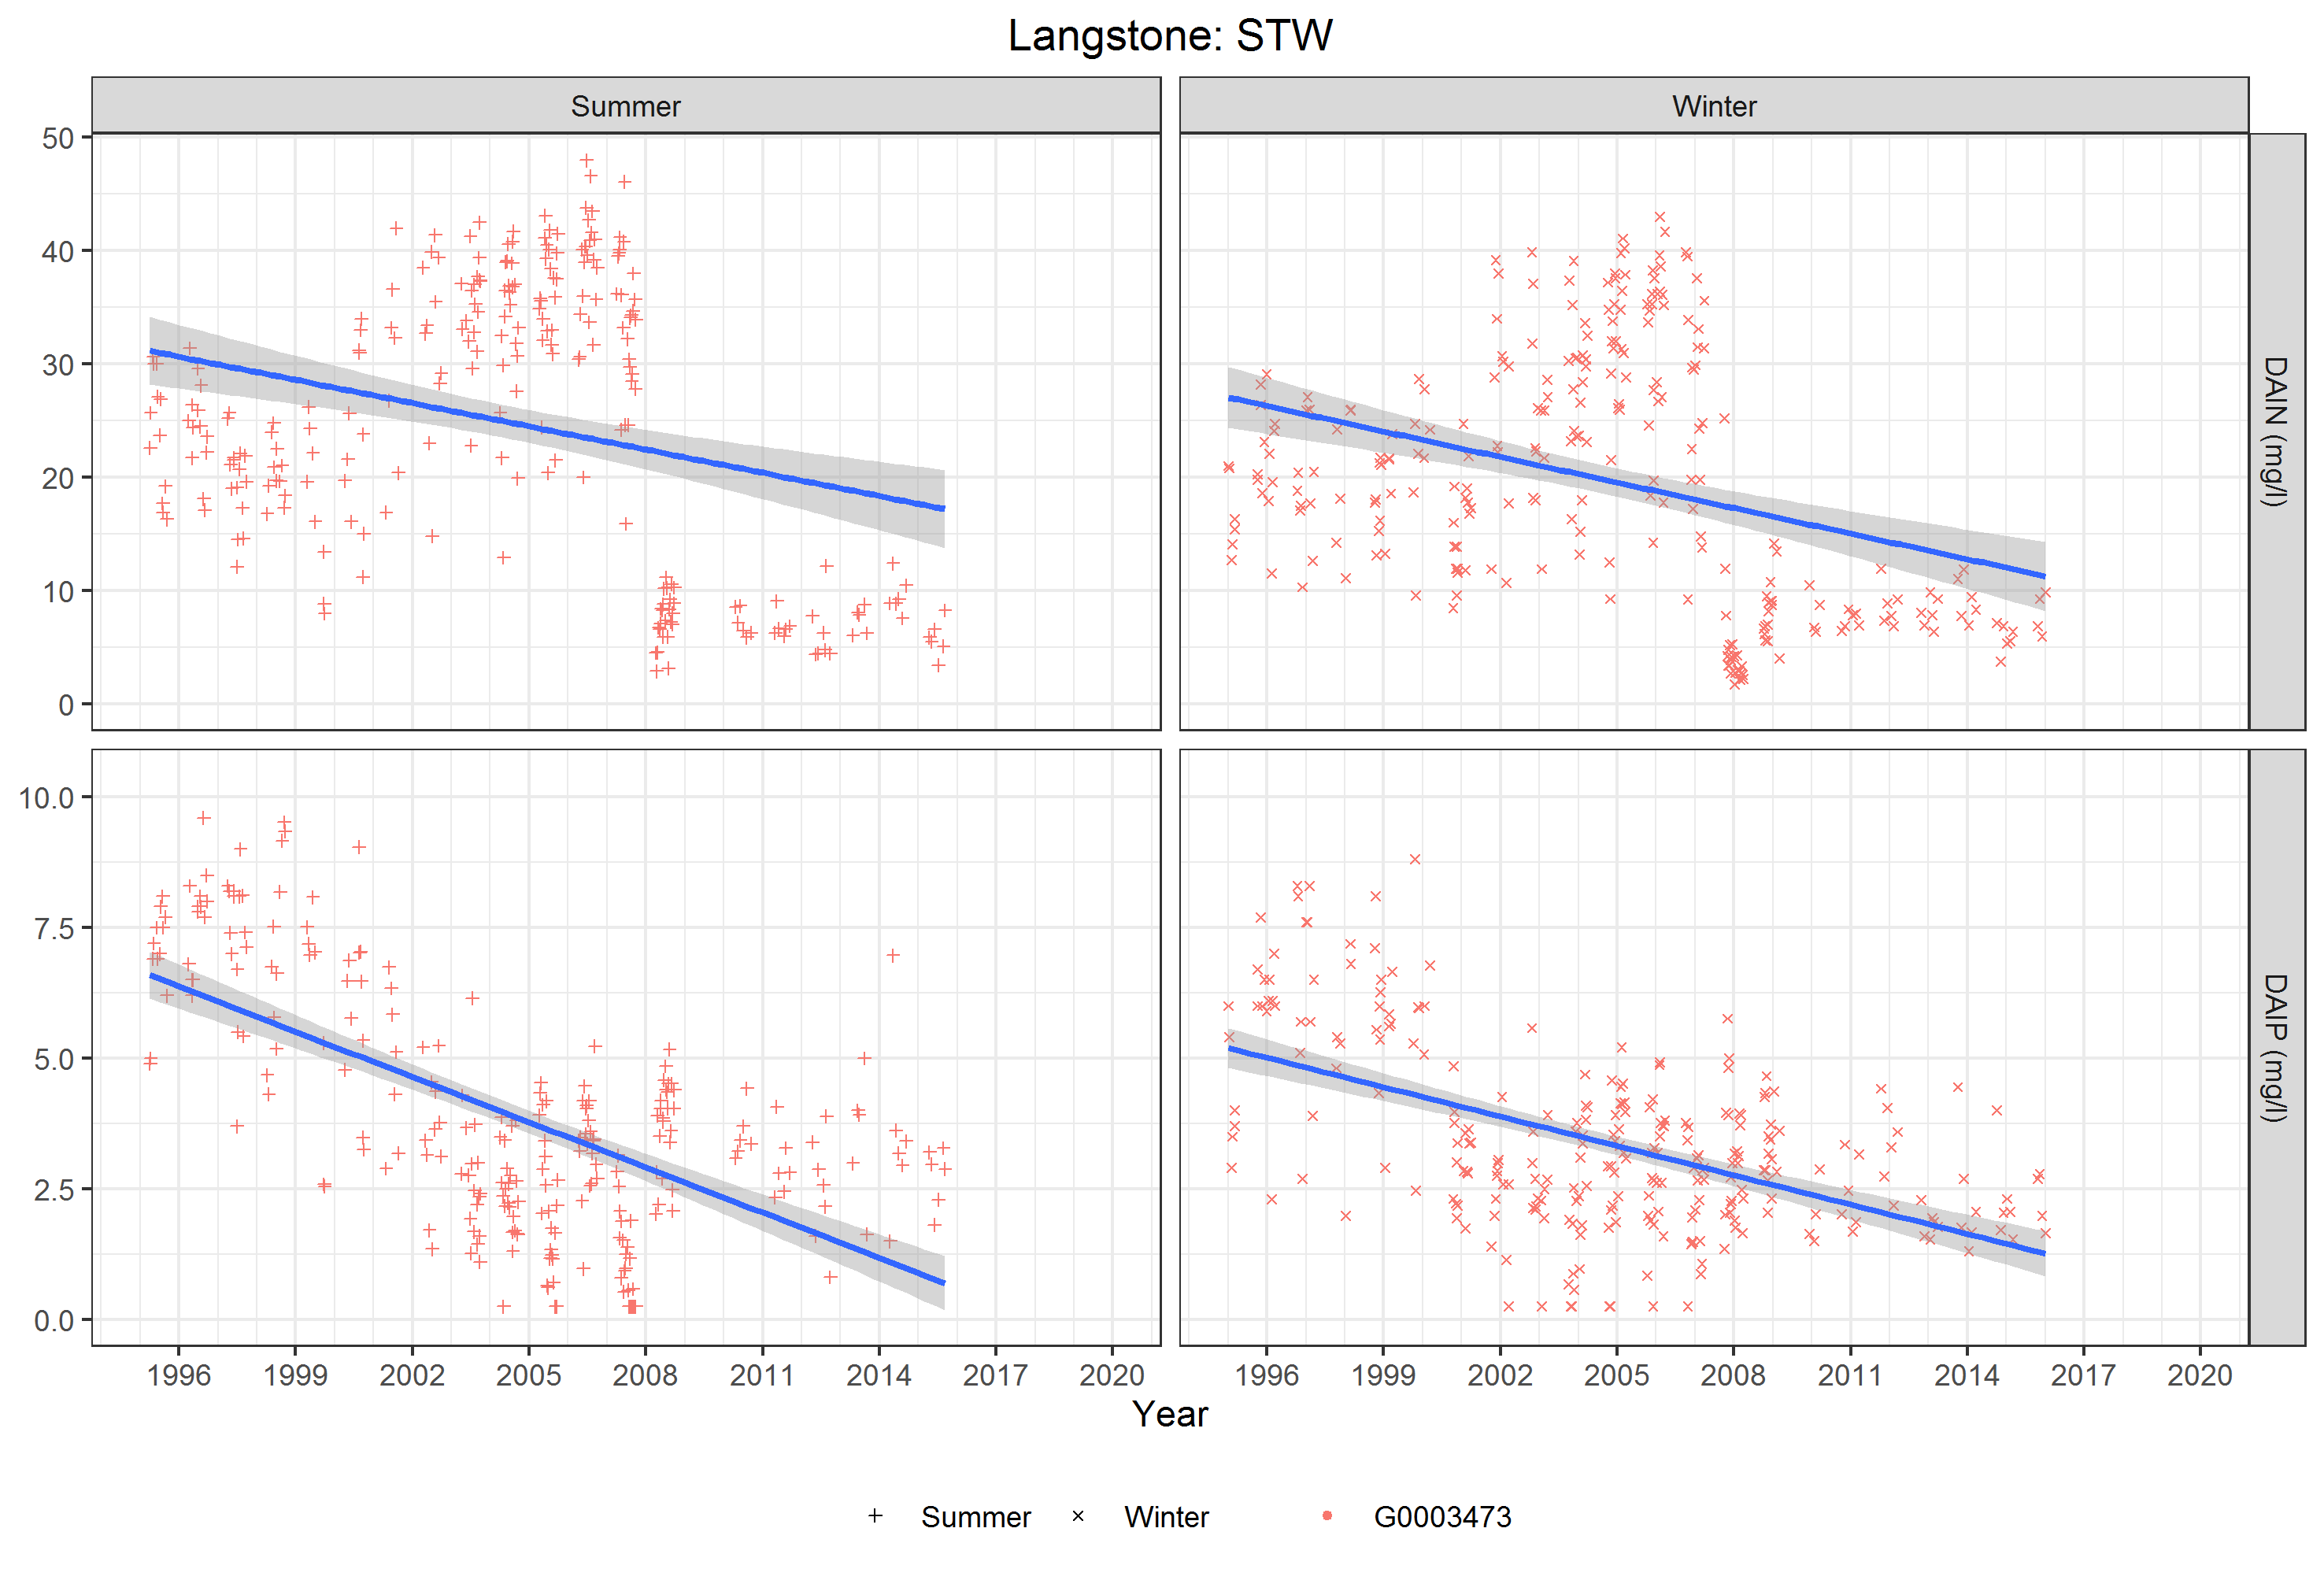


In [133]:
sew_notation = np.unique(df_sew["sample.samplingPoint.notation"])

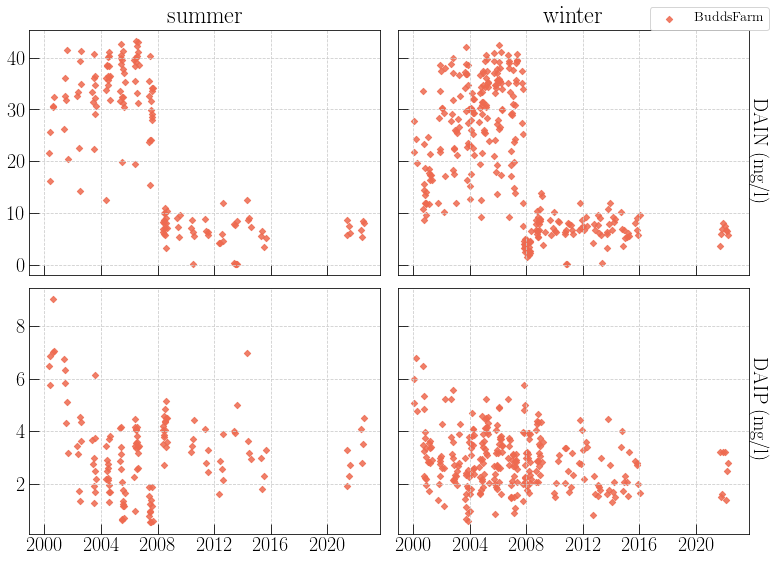

In [134]:
fig, axes = plt.subplots(nrows=2,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

axes[0,0].scatter(df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==0)]["Date"], \
                  df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                 label="BuddsFarm", marker="D")


axes[0,0].set_title("summer")

axes[0,1].scatter(df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==1)]["Date"], \
                  df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")

axes[0,1].set_title("winter")
axes[0, 1].yaxis.set_label_position("right")
axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)

axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')


axes[1,0].scatter(df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==0)]["Date"], \
                  df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")


axes[1,1].scatter(df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==1)]["Date"], \
                  df_sew[(df_sew["sample.samplingPoint.notation"]==sew_notation[0])&(df_sew["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, color="#EE6A50", alpha=0.85,\
                  marker="D")



axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)


axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
fig.legend(fontsize=14)

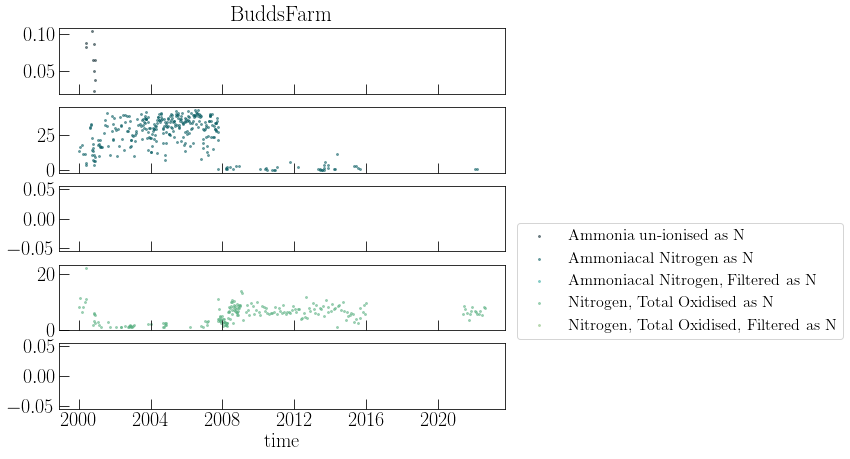

In [135]:
fig = plot_nutrientsdate(df_sew, DAIN_names, "BuddsFarm", color_N\
                             , bbox_to_anchor_=(1.5, .51), figsize_ = (8,7), sct_kwargs = scatter_params)

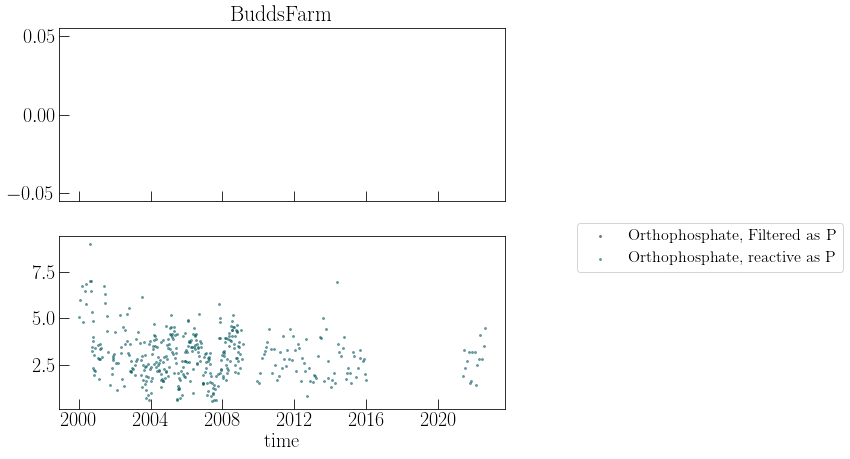

In [136]:
fig = plot_nutrientsdate(df_sew, DAIP_names, "BuddsFarm", color_N\
                             , bbox_to_anchor_=(1.5, .51), figsize_ = (8,7), sct_kwargs = scatter_params)

### Figure 5 in report:



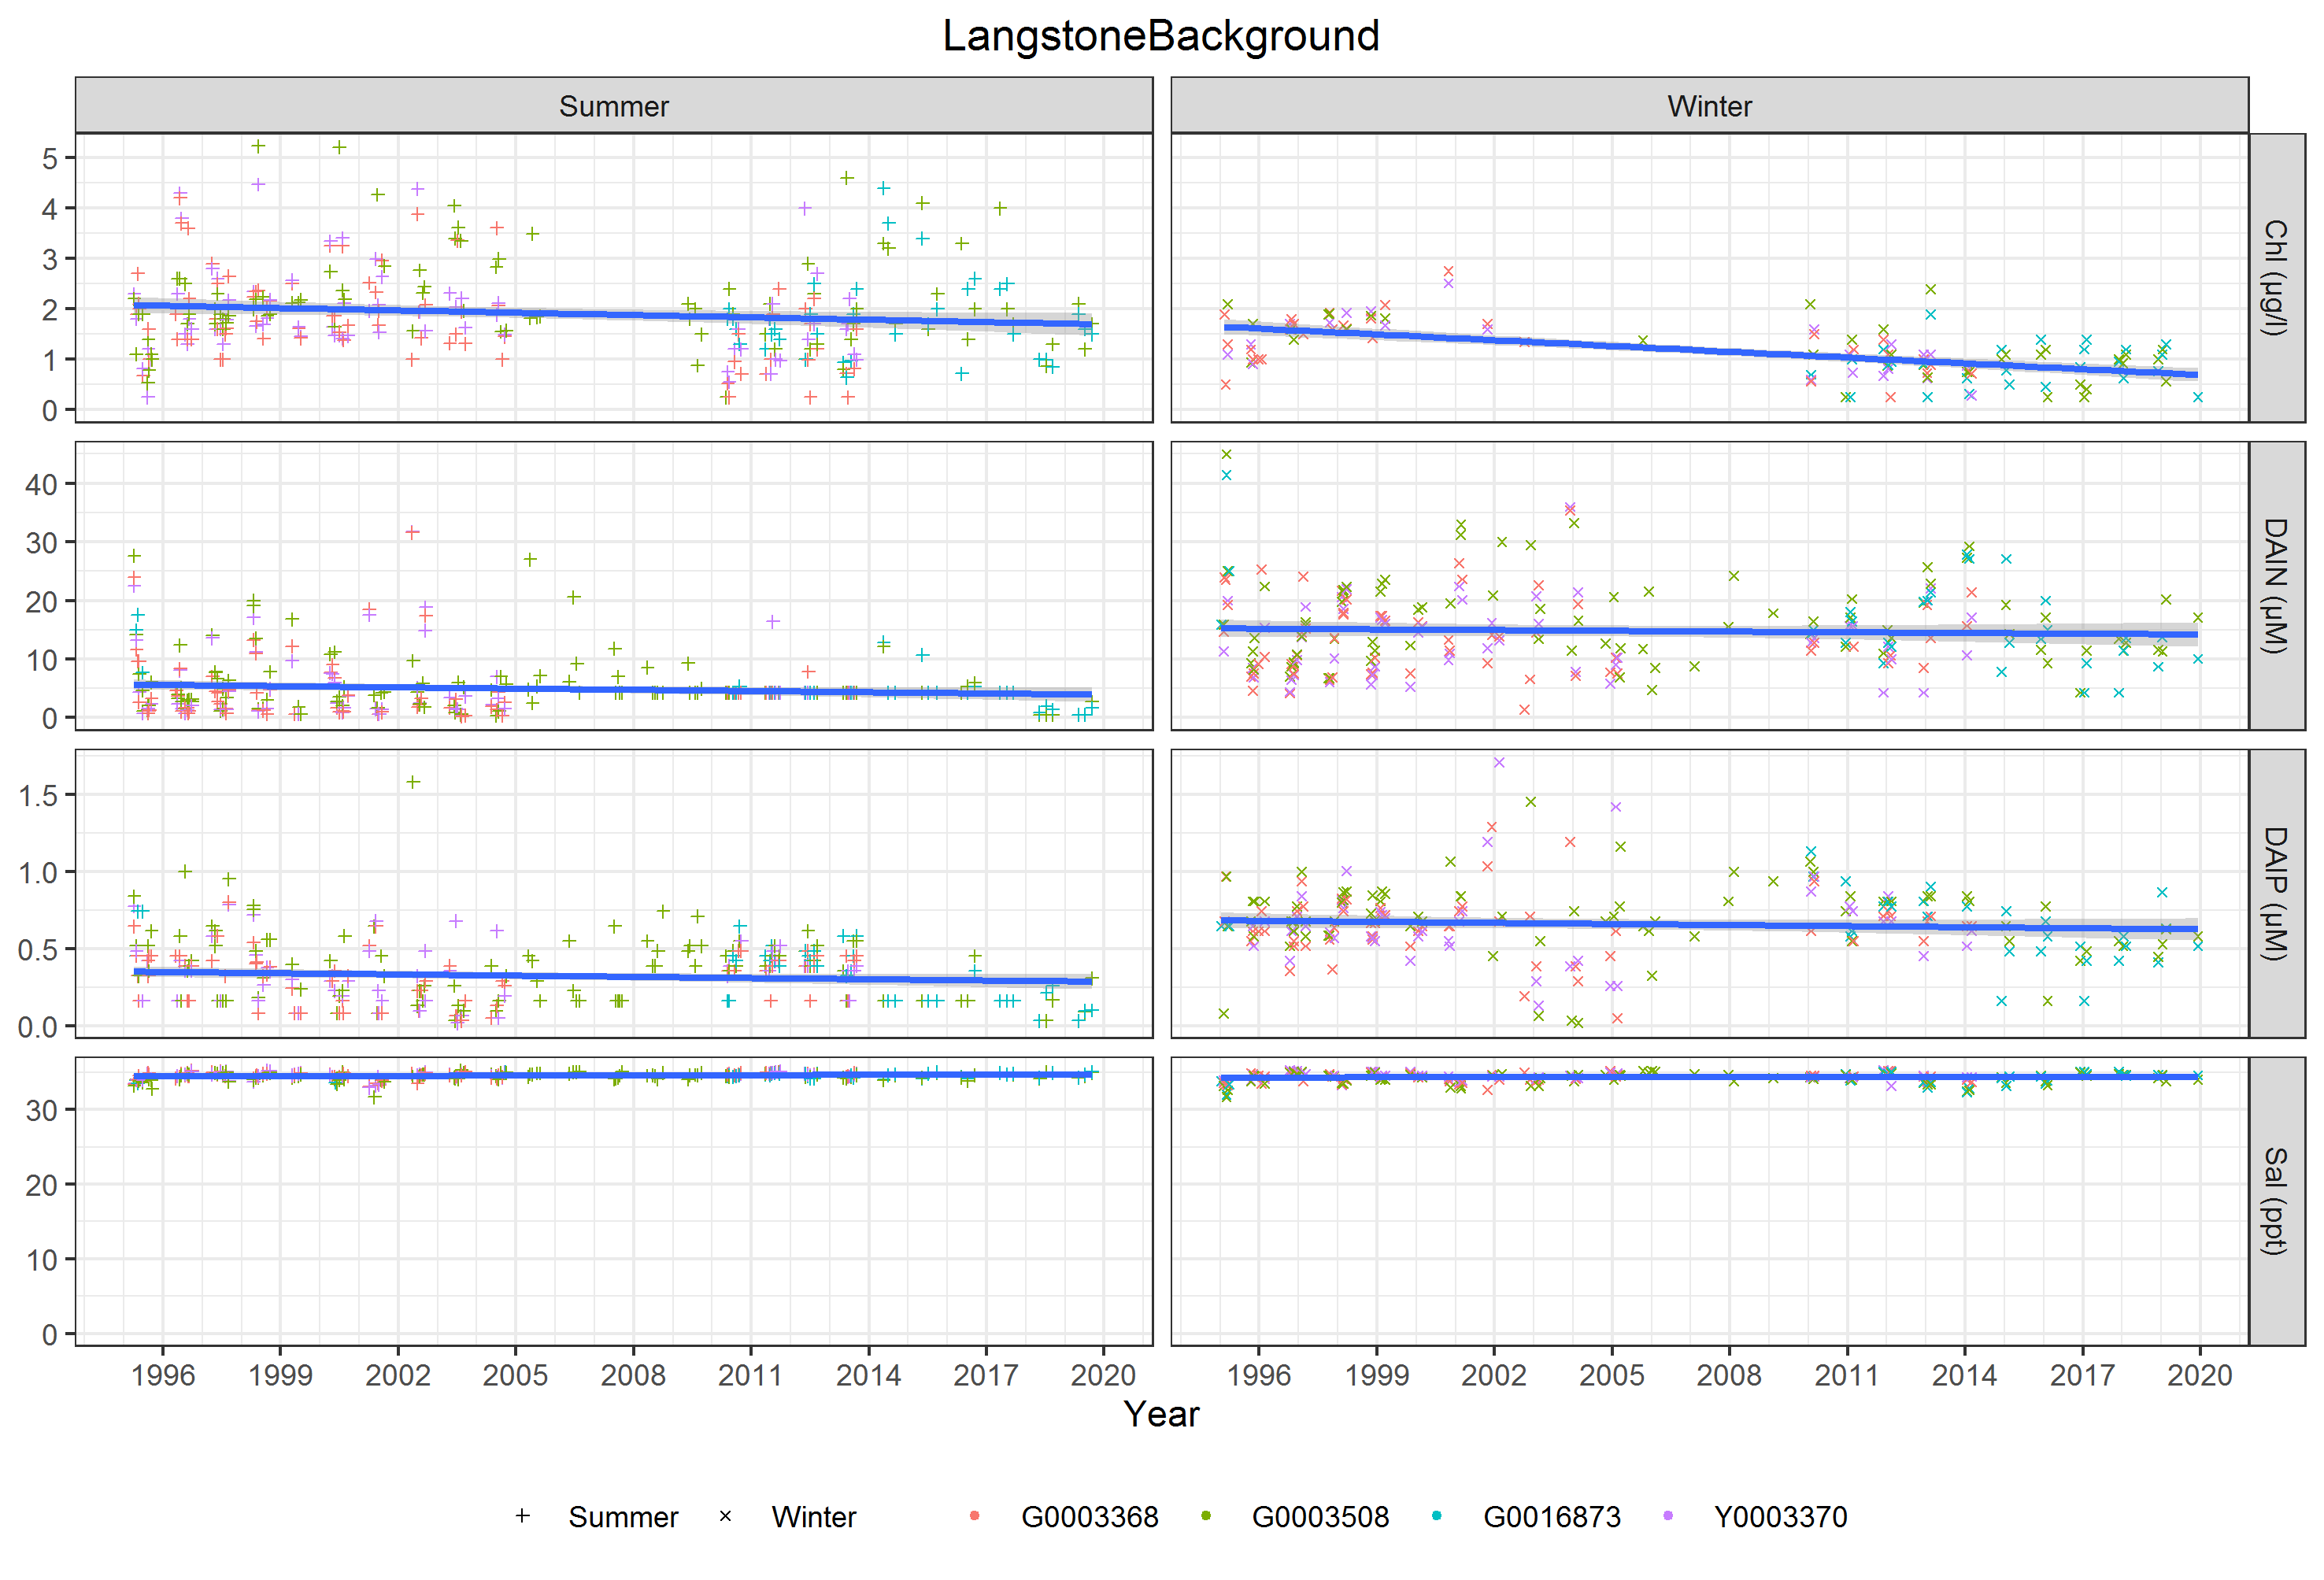


In [137]:
ocean_notation = np.unique(df_ocean["sample.samplingPoint.notation"])

In [138]:
ocean_notation

array(['SO-G0003368', 'SO-G0003508', 'SO-G0016873', 'SO-Y0003370'],
      dtype=object)

Text(0, 0.5, 'Salinity')

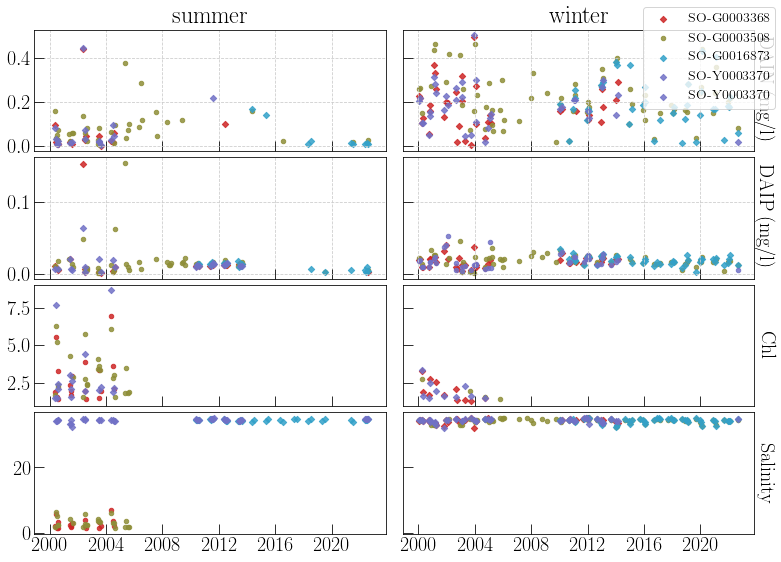

In [139]:
fig, axes = plt.subplots(nrows=4,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

axes[0,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                 label=str(ocean_notation[0]), marker="D")
axes[0,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 label=str(ocean_notation[1]))


axes[0,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#33A1C9", alpha=0.85,\
                 label=str(ocean_notation[2]), marker="D")



axes[0,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#7171C6", alpha=0.85,\
                 label=str(ocean_notation[3]), marker="D")





axes[0,0].set_title("summer")


axes[0,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[0,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[0,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#33A1C9", alpha=0.85,\
                  marker="D")



axes[0,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#7171C6", alpha=0.85,\
                  marker="D")



axes[0,1].set_title("winter")


axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')


axes[1,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )


axes[1,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#33A1C9", alpha=0.85,\
                 marker="D")



axes[1,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#7171C6", alpha=0.85,\
                 label=str(ocean_notation[3]), marker="D")



axes[1,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )


axes[1,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#33A1C9", alpha=0.85,\
                 marker="D")



axes[1,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#7171C6", alpha=0.85,\
                )




axes[2,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[2,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[2,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#33A1C9", alpha=0.85,\
                 marker="D")



axes[2,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#7171C6", alpha=0.85,\
                  marker="D")

axes[2,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[2,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[2,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#33A1C9", alpha=0.85,\
                  marker="D")



axes[2,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#7171C6", alpha=0.85,\
                  marker="D")



axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#33A1C9", alpha=0.85,\
                 marker="D")



axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#7171C6", alpha=0.85,\
                  marker="D")

axes[3,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[0])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[3,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[3,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[2])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#33A1C9", alpha=0.85,\
                  marker="D")



axes[3,1].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[3])&(df_ocean["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#7171C6", alpha=0.85,\
                  marker="D")



axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
fig.legend(fontsize=14)

axes[0, 1].yaxis.set_label_position("right")
axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)



axes[2, 1].yaxis.set_label_position("right")

axes[2, 1].set_ylabel("Chl", rotation=270, labelpad=20)


axes[3, 1].yaxis.set_label_position("right")

axes[3, 1].set_ylabel("Salinity", rotation=270, labelpad=20)


In [140]:
est_notation = np.unique(df_est["sample.samplingPoint.notation"])

In [141]:
est_notation

array(['SO-G0003467', 'SO-G0003468', 'SO-G0003484', 'SO-G0003493',
       'SO-G0015927', 'SO-G0016873', 'SO-G0016918', 'SO-G0016920',
       'SO-G0016921'], dtype=object)

In [142]:
same_node = np.concatenate(same_node)

In [143]:
same_node

array(['SO-G0015927', 'SO-G0016920'], dtype=object)

Text(0, 0.5, 'Salinity')

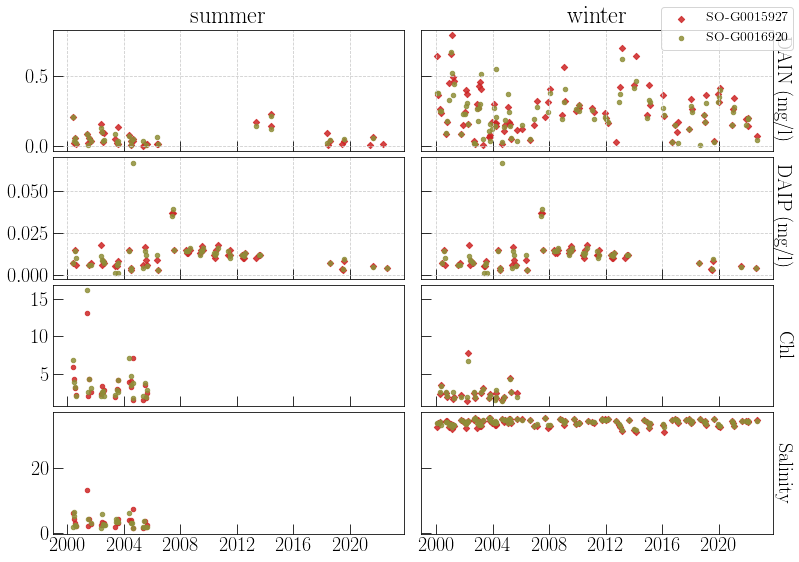

In [144]:
fig, axes = plt.subplots(nrows=4,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

axes[0,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                 label=str(same_node[0]), marker="D")
axes[0,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 label=str(same_node[1]))





axes[0,0].set_title("summer")


axes[0,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[0,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                )



axes[0,1].set_title("winter")


axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')


axes[1,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )


axes[1,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )





axes[2,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[2,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[2,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[2,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )




axes[3,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==ocean_notation[1])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )




axes[3,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==same_node[0])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[3,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==same_node[1])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )





axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
fig.legend(fontsize=14)

axes[0, 1].yaxis.set_label_position("right")
axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)



axes[2, 1].yaxis.set_label_position("right")

axes[2, 1].set_ylabel("Chl", rotation=270, labelpad=20)


axes[3, 1].yaxis.set_label_position("right")

axes[3, 1].set_ylabel("Salinity", rotation=270, labelpad=20)


Text(0, 0.5, 'Salinity')

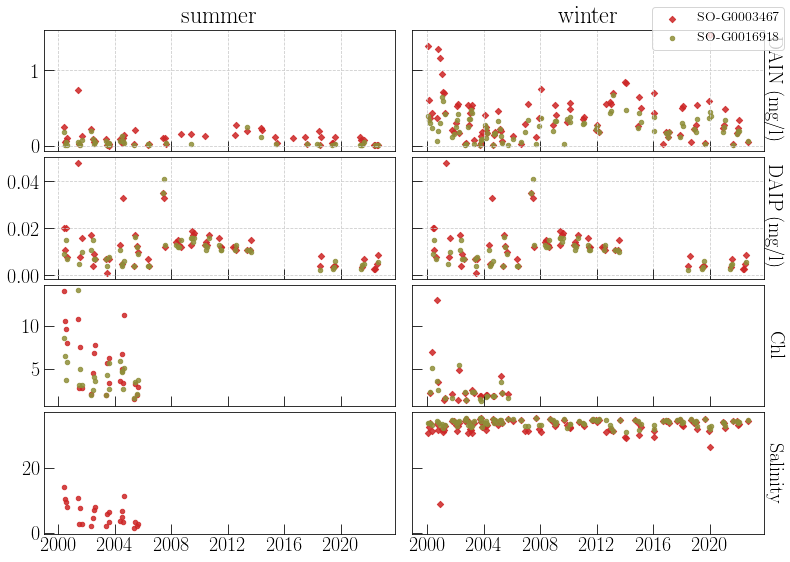

In [145]:
fig, axes = plt.subplots(nrows=4,ncols=2, sharey='row', sharex=True, figsize=(10,7))
fig.subplots_adjust(0,0,1.,1.,0.05,0.05)

axes[0,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                 label=str(est_notation[0]), marker="D")
axes[0,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 label=str(est_notation[6]))





axes[0,0].set_title("summer")


axes[0,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[0,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==1)][DAIN_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                )



axes[0,1].set_title("winter")


axes[0, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[0, 1].grid(which='major', color='#CCCCCC', linestyle='--')


axes[1,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )


axes[1,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[1,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)][DAIP_names].sum(min_count=1, axis=1), s=20, 
                  color="#8E8E38", alpha=0.85,\
                 )





axes[2,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[2,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )


axes[2,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[2,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[1])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[1])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )




axes[3,0].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#CD2626", alpha=0.85,\
                 )
axes[3,0].scatter(df_ocean[(df_ocean["sample.samplingPoint.notation"]==est_notation[6])&(df_ocean["season"]==0)]["Date"], \
                  df_ocean[(df_ocean["sample.samplingPoint.notation"]==est_notation[6])&(df_ocean["season"]==0)][Nutrients_Chl_Salinity_names[0]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )




axes[3,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)]["Date"], \
                 df_est[(df_est["sample.samplingPoint.notation"]==est_notation[0])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#CD2626", alpha=0.85,\
                  marker="D")
axes[3,1].scatter(df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==1)]["Date"], \
                  df_est[(df_est["sample.samplingPoint.notation"]==est_notation[6])&(df_est["season"]==1)][Nutrients_Chl_Salinity_names[1]], s=20, 
                  color="#8E8E38", alpha=0.85,\
                )





axes[1, 0].grid(which='major', color='#CCCCCC', linestyle='--')
axes[1, 1].grid(which='major', color='#CCCCCC', linestyle='--')
fig.legend(fontsize=14)

axes[0, 1].yaxis.set_label_position("right")
axes[0, 1].set_ylabel("DAIN (mg/l)", rotation=270, labelpad=20)
axes[1, 1].yaxis.set_label_position("right")

axes[1, 1].set_ylabel("DAIP (mg/l)", rotation=270, labelpad=20)



axes[2, 1].yaxis.set_label_position("right")

axes[2, 1].set_ylabel("Chl", rotation=270, labelpad=20)


axes[3, 1].yaxis.set_label_position("right")

axes[3, 1].set_ylabel("Salinity", rotation=270, labelpad=20)


## 3) Imputing

In [146]:
scatter_params_ = {'s':10, 'alpha':0.8}


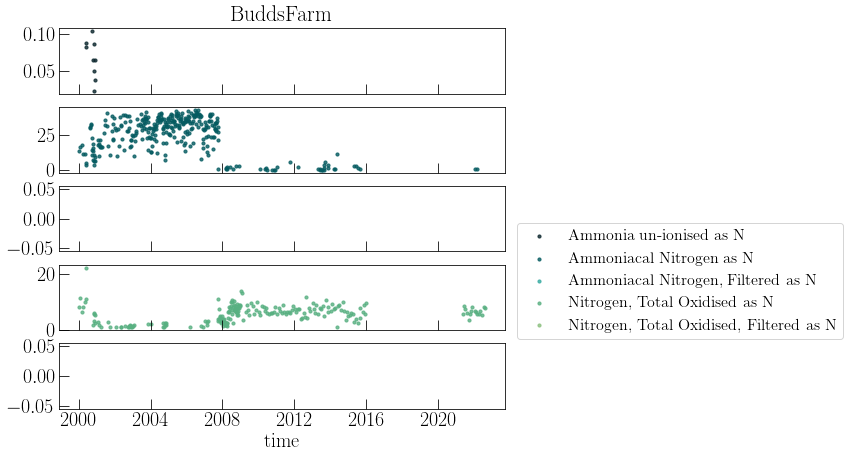

In [147]:
ig = plot_nutrientsdate(df_sew, DAIN_names, "BuddsFarm", color_N\
                             , bbox_to_anchor_=(1.5, .51), figsize_ = (8,7), sct_kwargs = scatter_params_)

### Let's try with a Gaussian Process

In [148]:
DAIN_names[1]

'Ammoniacal Nitrogen as N'

<AxesSubplot:title={'center':'BuddsFarm'}, xlabel='time'>

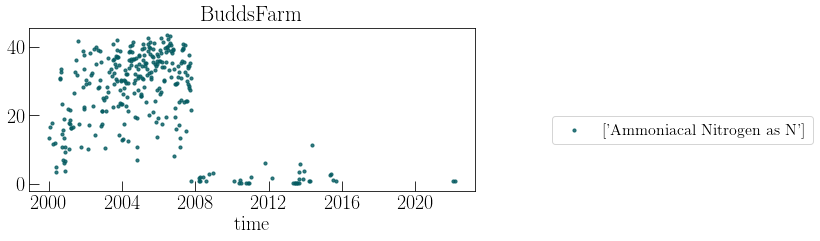

In [149]:
plot_nutrientsdate(df_sew, ['Ammoniacal Nitrogen as N'], "BuddsFarm", color_N[1]\
                             , bbox_to_anchor_=(1.5, .51), figsize_ = (8,3), sct_kwargs = scatter_params_)

In [150]:
A_date = df_sew[["Date", 'Ammoniacal Nitrogen as N']].sort_values(by="Date", ascending=True).reset_index()

In [151]:
A_date["Date"] = pd.to_datetime(A_date["Date"], errors='coerce')

In [152]:
A_date["Date"] 

0     2000-01-13
1     2000-01-18
2     2000-03-10
3     2000-04-06
4     2000-05-03
         ...    
835   2022-07-12
836   2022-07-13
837   2022-07-22
838   2022-07-26
839   2022-08-16
Name: Date, Length: 840, dtype: datetime64[ns]

In [153]:
import datetime

In [154]:
A_sec = np.array([(A_date.loc[i, "Date"]-datetime.datetime.strptime("20000113", "%Y%m%d")).total_seconds()*10**-8 for i in range(len(A_date["Date"]))])

In [155]:
fitting = np.polyfit(A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index], A_date["Ammoniacal Nitrogen as N"][A_date["Ammoniacal Nitrogen as N"].dropna().index], 
                     deg=10)

In [156]:
p = np.poly1d(fitting)


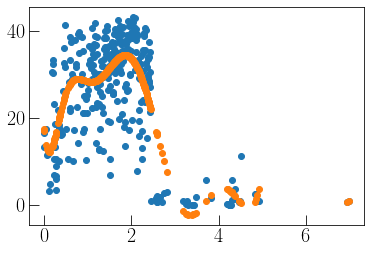

In [157]:
plt.scatter(A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index], A_date["Ammoniacal Nitrogen as N"][A_date["Ammoniacal Nitrogen as N"].dropna().index])

plt.scatter(A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index], p(A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index]))

In [158]:
X = A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index].reshape(-1, 1)
y = A_date["Ammoniacal Nitrogen as N"][A_date["Ammoniacal Nitrogen as N"].dropna().index]

In [159]:
y_mean = p(A_sec[A_date["Ammoniacal Nitrogen as N"].dropna().index])

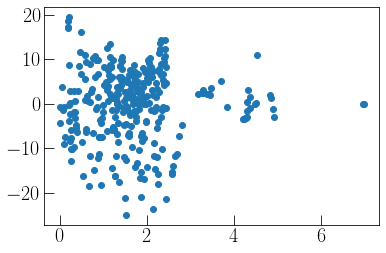

In [160]:
plt.scatter(X, y-y_mean)

In [161]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = WhiteKernel(noise_level=5)

In [162]:
from sklearn.gaussian_process.kernels import (RationalQuadratic, Exponentiation)

In [163]:
irregularities_kernel = RationalQuadratic(length_scale=0.25, alpha=1.0)


In [164]:
kernel = (noise_kernel + irregularities_kernel)

In [165]:
from sklearn.gaussian_process import GaussianProcessRegressor

gaussian_process = GaussianProcessRegressor(kernel=kernel, normalize_y=True)
gaussian_process.fit(X, y-y_mean)


GaussianProcessRegressor(kernel=WhiteKernel(noise_level=5) + RationalQuadratic(alpha=1, length_scale=0.25),
                         normalize_y=True)

In [166]:
today = datetime.datetime.now()
current_month = today.year + today.month / 12

dates_random = pd.to_datetime(pd.date_range(start='1/1/2000', end=today, periods =3000).date, errors='coerce') 

X_test = np.array((dates_random-datetime.datetime.strptime("20000113", "%Y%m%d")).total_seconds()*10**-8).reshape(-1,1)

In [167]:
mean_y_pred_rec, std_y_pred_rec = gaussian_process.predict(X, return_std=True)


mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)

Text(0, 0.5, 'Ammonia')

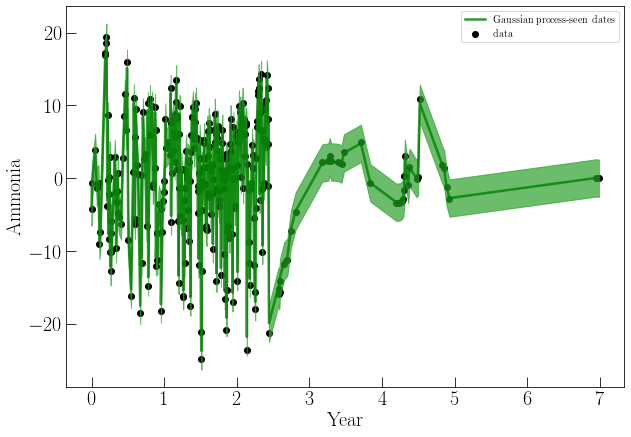

In [168]:
fig, axes = plt.subplots( figsize=(10,7))

plt.plot(X, mean_y_pred_rec, color="green", alpha=0.8, label="Gaussian process-seen dates")

plt.scatter(X, y-y_mean, color="black", label="data")

plt.fill_between(
    X.ravel(),
    mean_y_pred_rec - std_y_pred_rec,
    mean_y_pred_rec + std_y_pred_rec,
    color="tab:green",
    alpha=0.7,
)



plt.legend()
plt.xlabel("Year")
plt.ylabel("Ammonia")


Text(0, 0.5, 'Ammonia')

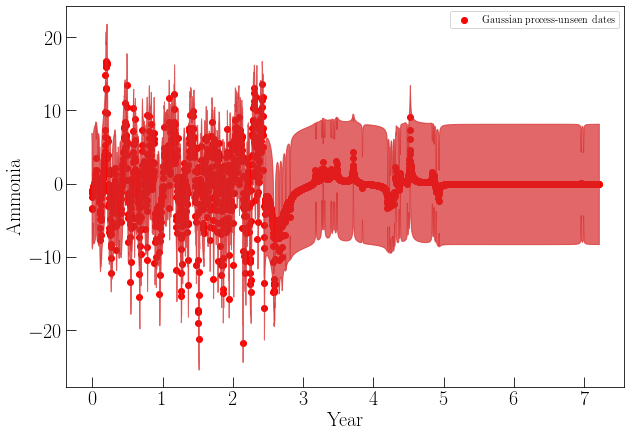

In [169]:
fig, axes = plt.subplots( figsize=(10,7))

plt.scatter(X_test, mean_y_pred, color="red", alpha=1, label="Gaussian process-unseen dates")


plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:red",
    alpha=0.7,
)



plt.legend()
plt.xlabel("Year")
plt.ylabel("Ammonia")
